# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.

test

In [ ]:
%%script echo skipping

!jupyter nbconvert pt4.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


In [ ]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Constants and flags to set
Defining some constants and parameters for convenience.

In [ ]:

N_TRIALS = 150 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..

# Hyperparameters when no hyperparameter optimization is performed. 
N_LAYERS_NO_OPT = 2
N_UNITS_NO_OPT = [600, 200]
HIDDEN_ACTIVATION_NAME_NO_OPT = "Sigmoid"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "MSE"
OPTIMIZER_NAME_NO_OPT = "Adam"
LR_NO_OPT = 6e-3
BATCH_SIZE_NO_OPT = 32
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(2) # Uncomment for pseudorandom data.

## Generating the data

In [ ]:

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p

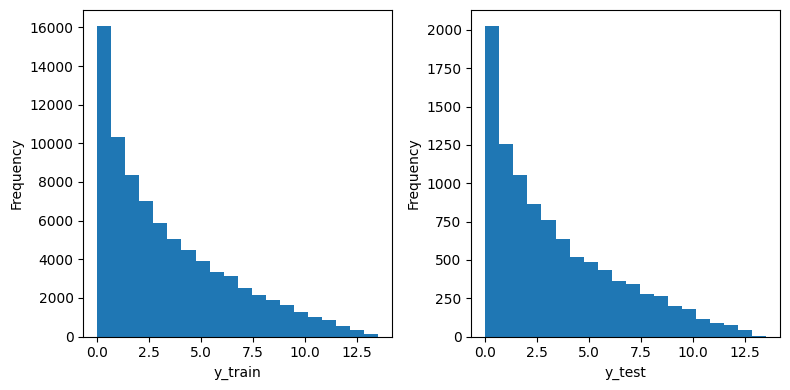

Shape of x_train: torch.Size([80000, 3])
Shape of y_train: torch.Size([80000])
Shape of x_test: torch.Size([10000, 3])
Shape of y_test: torch.Size([10000])


In [ ]:
# Sampling the primitive variables using the sample_primitive_variables function
rho_train, vx_train, epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test, epsilon_test = sample_primitive_variables(n_test_samples)

# Generating the input and output data for train and test sets using the modified functions
x_train = generate_input_data(rho_train, vx_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, epsilon_test) 
y_test = generate_labels(rho_test, epsilon_test) 

# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20)
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20)
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Checking the shapes of the data tensors
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 1, 3)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 256) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
        )
        output_activation_name = trial.suggest_categorical(
            "output_activation", ["Linear", "ReLU"]
        ) 
        loss_name = trial.suggest_categorical(
            "loss", ["MSE", "MAE", "Huber", "LogCosh"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        batch_size = trial.suggest_int("batch_size", 32, 256)
        n_epochs = trial.suggest_int("n_epochs", 50, 100) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
        )
    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    # Creating the optimizer from its name
    if optimizer_name == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=lr)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=lr)
    else:
        # Added creating the Adagrad optimizer
        optimizer = optim.Adagrad(net.parameters(), lr=lr)

    # Creating the learning rate scheduler from its name
    if scheduler_name == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_name == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    elif scheduler_name == "CosineAnnealingLR":
        # Added creating the CosineAnnealingLR scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    elif scheduler_name == "ReduceLROnPlateau":
        # Added creating the ReduceLROnPlateau scheduler
        # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
        #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
        #)
        # Use Dieseldorst et al. settings and add to that a minimum lr.
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode="min", factor=0.5, patience=5, threshold=0.0005, min_lr=1e-6
                )
    else:
        scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr


 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-13 12:59:57,198] A new study created in memory with name: no-name-0a26b0b9-e16e-4aec-90f4-90cf1f99e304
<ipython-input-11-bd4fe74facdf>:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


Epoch 1: Train Loss: 0.8753, Test Loss: 0.1212, Train L1 Norm: 1.7944, Test L1 Norm: 0.4412, Train Linf Norm: 174.4829, Test Linf Norm: 30.3003
Epoch 2: Train Loss: 0.3429, Test Loss: 0.1893, Train L1 Norm: 0.9073, Test L1 Norm: 0.7962, Train Linf Norm: 87.3479, Test Linf Norm: 52.8811
Epoch 3: Train Loss: 0.1294, Test Loss: 0.0607, Train L1 Norm: 0.6551, Test L1 Norm: 0.5575, Train Linf Norm: 68.7484, Test Linf Norm: 39.0456
Epoch 4: Train Loss: 0.0321, Test Loss: 0.0091, Train L1 Norm: 0.4261, Test L1 Norm: 0.4391, Train Linf Norm: 41.4916, Test Linf Norm: 25.4289
Epoch 5: Train Loss: 0.0082, Test Loss: 0.0060, Train L1 Norm: 0.2797, Test L1 Norm: 0.3863, Train Linf Norm: 27.3551, Test Linf Norm: 21.2541
Epoch 6: Train Loss: 0.0061, Test Loss: 0.0059, Train L1 Norm: 0.2279, Test L1 Norm: 0.3578, Train Linf Norm: 21.5777, Test Linf Norm: 19.1322
Epoch 7: Train Loss: 0.0053, Test Loss: 0.0048, Train L1 Norm: 0.2264, Test L1 Norm: 0.3629, Train Linf Norm: 21.5370, Test Linf Norm: 19.452

[I 2023-05-13 13:01:54,876] Trial 0 finished with value: 0.2666031016021967 and parameters: {'n_layers': 1, 'n_units_0': 116, 'hidden_activation': 'ELU', 'output_activation': 'Linear', 'loss': 'LogCosh', 'optimizer': 'SGD', 'lr': 0.003377330990564352, 'batch_size': 178, 'n_epochs': 83, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 0.2666031016021967.


Epoch 83: Train Loss: 0.0006, Test Loss: 0.0005, Train L1 Norm: 0.2547, Test L1 Norm: 0.2666, Train Linf Norm: 33.1871, Test Linf Norm: 24.8669
Epoch 1: Train Loss: 0.1285, Test Loss: 0.0281, Train L1 Norm: 0.2789, Test L1 Norm: 0.0959, Train Linf Norm: 25.5395, Test Linf Norm: 8.2524
Epoch 2: Train Loss: 0.0431, Test Loss: 0.0328, Train L1 Norm: 0.0732, Test L1 Norm: 0.0384, Train Linf Norm: 6.3384, Test Linf Norm: 2.4796
Epoch 3: Train Loss: 0.0356, Test Loss: 0.0120, Train L1 Norm: 0.0705, Test L1 Norm: 0.0325, Train Linf Norm: 6.6854, Test Linf Norm: 2.0749
Epoch 4: Train Loss: 0.0327, Test Loss: 0.0577, Train L1 Norm: 0.0607, Test L1 Norm: 0.0932, Train Linf Norm: 5.6556, Test Linf Norm: 6.5428
Epoch 5: Train Loss: 0.0304, Test Loss: 0.0289, Train L1 Norm: 0.0546, Test L1 Norm: 0.0493, Train Linf Norm: 5.0432, Test Linf Norm: 2.7999
Epoch 6: Train Loss: 0.0302, Test Loss: 0.0398, Train L1 Norm: 0.0550, Test L1 Norm: 0.1029, Train Linf Norm: 5.2726, Test Linf Norm: 7.5701
Epoch 7: 

[I 2023-05-13 13:03:59,081] Trial 1 finished with value: 0.012162298429012298 and parameters: {'n_layers': 3, 'n_units_0': 69, 'n_units_1': 185, 'n_units_2': 123, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0008636066951271179, 'batch_size': 148, 'n_epochs': 71, 'scheduler': 'None'}. Best is trial 1 with value: 0.012162298429012298.


Epoch 71: Train Loss: 0.0173, Test Loss: 0.0105, Train L1 Norm: 0.0246, Test L1 Norm: 0.0122, Train Linf Norm: 2.0320, Test Linf Norm: 0.7859
Epoch 1: Train Loss: 0.2600, Test Loss: 0.0384, Train L1 Norm: 0.3952, Test L1 Norm: 0.2009, Train Linf Norm: 9.7175, Test Linf Norm: 3.7135
Epoch 2: Train Loss: 0.1226, Test Loss: 0.0344, Train L1 Norm: 0.2983, Test L1 Norm: 0.1608, Train Linf Norm: 8.1090, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.0993, Test Loss: 0.0256, Train L1 Norm: 0.2325, Test L1 Norm: 0.1572, Train Linf Norm: 3.1624, Test Linf Norm: 1.8703
Epoch 4: Train Loss: 0.0894, Test Loss: 0.0900, Train L1 Norm: 0.2769, Test L1 Norm: 0.1913, Train Linf Norm: 8.3358, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 0.0806, Test Loss: 0.0452, Train L1 Norm: 0.2123, Test L1 Norm: 0.2455, Train Linf Norm: 1.6561, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.0758, Test Loss: 0.0645, Train L1 Norm: 0.2281, Test L1 Norm: 0.1935, Train Linf Norm: 3.6720, Test Linf Norm: 1.0791
Epoch 7: Tra

[I 2023-05-13 13:06:02,341] Trial 2 finished with value: 0.15276658617705108 and parameters: {'n_layers': 2, 'n_units_0': 134, 'n_units_1': 31, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 0.008241743821984265, 'batch_size': 110, 'n_epochs': 70, 'scheduler': 'None'}. Best is trial 1 with value: 0.012162298429012298.


Epoch 70: Train Loss: 0.0302, Test Loss: 0.0129, Train L1 Norm: 0.1773, Test L1 Norm: 0.1528, Train Linf Norm: 1.2902, Test Linf Norm: 1.0045
Epoch 1: Train Loss: 1.6417, Test Loss: 1.2943, Train L1 Norm: 3.6255, Test L1 Norm: 2.7636, Train Linf Norm: 454.4988, Test Linf Norm: 276.8031
Epoch 2: Train Loss: 1.1562, Test Loss: 1.0468, Train L1 Norm: 4.1541, Test L1 Norm: 3.6981, Train Linf Norm: 617.3304, Test Linf Norm: 441.8863
Epoch 3: Train Loss: 0.9840, Test Loss: 0.9249, Train L1 Norm: 4.6978, Test L1 Norm: 4.3033, Train Linf Norm: 713.1599, Test Linf Norm: 521.0179
Epoch 4: Train Loss: 0.8831, Test Loss: 0.8409, Train L1 Norm: 4.9538, Test L1 Norm: 4.3240, Train Linf Norm: 753.4308, Test Linf Norm: 521.7095
Epoch 5: Train Loss: 0.8112, Test Loss: 0.7785, Train L1 Norm: 4.7848, Test L1 Norm: 4.0287, Train Linf Norm: 736.5158, Test Linf Norm: 483.7067
Epoch 6: Train Loss: 0.7581, Test Loss: 0.7341, Train L1 Norm: 4.3865, Test L1 Norm: 3.7008, Train Linf Norm: 668.2146, Test Linf Nor

[I 2023-05-13 13:07:50,066] Trial 3 finished with value: 1.1908909585677088 and parameters: {'n_layers': 1, 'n_units_0': 246, 'hidden_activation': 'Tanh', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'SGD', 'lr': 0.0007264697181499317, 'batch_size': 207, 'n_epochs': 90, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.012162298429012298.


Epoch 90: Train Loss: 0.0879, Test Loss: 0.0861, Train L1 Norm: 1.4115, Test L1 Norm: 1.1909, Train Linf Norm: 247.4672, Test Linf Norm: 170.2325
Epoch 1: Train Loss: 0.1988, Test Loss: 0.0491, Train L1 Norm: 0.7972, Test L1 Norm: 0.6625, Train Linf Norm: 96.0523, Test Linf Norm: 86.0021
Epoch 2: Train Loss: 0.0590, Test Loss: 0.0267, Train L1 Norm: 0.5049, Test L1 Norm: 0.3208, Train Linf Norm: 72.9013, Test Linf Norm: 41.5822
Epoch 3: Train Loss: 0.0420, Test Loss: 0.0514, Train L1 Norm: 0.4034, Test L1 Norm: 0.2267, Train Linf Norm: 53.9812, Test Linf Norm: 25.8618
Epoch 4: Train Loss: 0.0368, Test Loss: 0.0313, Train L1 Norm: 0.3409, Test L1 Norm: 0.3012, Train Linf Norm: 43.1833, Test Linf Norm: 34.2043
Epoch 5: Train Loss: 0.0309, Test Loss: 0.0083, Train L1 Norm: 0.3296, Test L1 Norm: 0.3165, Train Linf Norm: 43.4709, Test Linf Norm: 44.2488
Epoch 6: Train Loss: 0.0268, Test Loss: 0.0023, Train L1 Norm: 0.2750, Test L1 Norm: 0.1166, Train Linf Norm: 33.2975, Test Linf Norm: 15.4

[I 2023-05-13 13:09:39,876] Trial 4 finished with value: 0.05460544927883893 and parameters: {'n_layers': 1, 'n_units_0': 219, 'hidden_activation': 'ELU', 'output_activation': 'Linear', 'loss': 'LogCosh', 'optimizer': 'RMSprop', 'lr': 0.002311865998988452, 'batch_size': 245, 'n_epochs': 95, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.012162298429012298.


Epoch 95: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0691, Test L1 Norm: 0.0546, Train Linf Norm: 10.6309, Test Linf Norm: 6.3310
Epoch 1: Train Loss: 0.3444, Test Loss: 0.0263, Train L1 Norm: 1.3099, Test L1 Norm: 0.3661, Train Linf Norm: 89.3756, Test Linf Norm: 18.7099


[I 2023-05-13 13:09:43,930] Trial 5 pruned. 


Epoch 2: Train Loss: 0.0974, Test Loss: 0.0224, Train L1 Norm: 0.6263, Test L1 Norm: 0.5955, Train Linf Norm: 40.0184, Test Linf Norm: 31.4455
Epoch 1: Train Loss: 0.6379, Test Loss: 0.0899, Train L1 Norm: 0.5649, Test L1 Norm: 0.3392, Train Linf Norm: 22.3560, Test Linf Norm: 15.1918
Epoch 2: Train Loss: 0.0535, Test Loss: 0.0513, Train L1 Norm: 0.1952, Test L1 Norm: 0.1634, Train Linf Norm: 5.2629, Test Linf Norm: 1.0186
Epoch 3: Train Loss: 0.0277, Test Loss: 0.0109, Train L1 Norm: 0.1559, Test L1 Norm: 0.0998, Train Linf Norm: 3.9813, Test Linf Norm: 1.0649
Epoch 4: Train Loss: 0.0196, Test Loss: 0.0068, Train L1 Norm: 0.1427, Test L1 Norm: 0.0762, Train Linf Norm: 4.3769, Test Linf Norm: 1.0316
Epoch 5: Train Loss: 0.0156, Test Loss: 0.0207, Train L1 Norm: 0.1116, Test L1 Norm: 0.1102, Train Linf Norm: 2.4989, Test Linf Norm: 0.9864
Epoch 6: Train Loss: 0.0139, Test Loss: 0.0058, Train L1 Norm: 0.1125, Test L1 Norm: 0.0665, Train Linf Norm: 3.2948, Test Linf Norm: 1.5246
Epoch 7: 

[I 2023-05-13 13:12:03,036] Trial 6 finished with value: 0.10186370426788927 and parameters: {'n_layers': 2, 'n_units_0': 223, 'n_units_1': 164, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.0001702752375191126, 'batch_size': 90, 'n_epochs': 67, 'scheduler': 'None'}. Best is trial 1 with value: 0.012162298429012298.


Epoch 67: Train Loss: 0.0028, Test Loss: 0.0085, Train L1 Norm: 0.0474, Test L1 Norm: 0.1019, Train Linf Norm: 1.6959, Test Linf Norm: 0.9847


[I 2023-05-13 13:12:04,686] Trial 7 pruned. 


Epoch 1: Train Loss: 2.8128, Test Loss: 2.8210, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-13 13:12:06,191] Trial 8 pruned. 


Epoch 1: Train Loss: 2.0979, Test Loss: 1.8959, Train L1 Norm: 11.7428, Test L1 Norm: 14.8307, Train Linf Norm: 1069.5862, Test Linf Norm: 1094.2465
Epoch 1: Train Loss: 0.2093, Test Loss: 0.1393, Train L1 Norm: 0.3226, Test L1 Norm: 0.1451, Train Linf Norm: 32.2645, Test Linf Norm: 10.5770
Epoch 2: Train Loss: 0.1359, Test Loss: 0.1835, Train L1 Norm: 0.2438, Test L1 Norm: 0.2345, Train Linf Norm: 28.1060, Test Linf Norm: 19.6228
Epoch 3: Train Loss: 0.1306, Test Loss: 0.1149, Train L1 Norm: 0.2228, Test L1 Norm: 0.2454, Train Linf Norm: 24.6027, Test Linf Norm: 24.7980
Epoch 4: Train Loss: 0.1266, Test Loss: 0.0588, Train L1 Norm: 0.2167, Test L1 Norm: 0.0730, Train Linf Norm: 23.6977, Test Linf Norm: 5.5693
Epoch 5: Train Loss: 0.1232, Test Loss: 0.0467, Train L1 Norm: 0.2272, Test L1 Norm: 0.1106, Train Linf Norm: 26.2711, Test Linf Norm: 11.0904
Epoch 6: Train Loss: 0.1206, Test Loss: 0.1009, Train L1 Norm: 0.2012, Test L1 Norm: 0.2054, Train Linf Norm: 21.9453, Test Linf Norm: 18

[I 2023-05-13 13:13:30,026] Trial 9 finished with value: 0.030238904572091996 and parameters: {'n_layers': 1, 'n_units_0': 145, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0007859634379848667, 'batch_size': 197, 'n_epochs': 66, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 1 with value: 0.012162298429012298.


Epoch 66: Train Loss: 0.0135, Test Loss: 0.0183, Train L1 Norm: 0.0316, Test L1 Norm: 0.0302, Train Linf Norm: 3.6292, Test Linf Norm: 2.4258


[I 2023-05-13 13:13:35,830] Trial 10 pruned. 


Epoch 1: Train Loss: 2.3143, Test Loss: 1.6959, Train L1 Norm: 3.2532, Test L1 Norm: 4.4621, Train Linf Norm: 76.5366, Test Linf Norm: 90.0117
Epoch 1: Train Loss: 0.1776, Test Loss: 0.0270, Train L1 Norm: 0.3669, Test L1 Norm: 0.0583, Train Linf Norm: 39.3818, Test Linf Norm: 6.1259
Epoch 2: Train Loss: 0.0413, Test Loss: 0.0395, Train L1 Norm: 0.0779, Test L1 Norm: 0.0434, Train Linf Norm: 10.2586, Test Linf Norm: 3.4990
Epoch 3: Train Loss: 0.0358, Test Loss: 0.0138, Train L1 Norm: 0.0792, Test L1 Norm: 0.0393, Train Linf Norm: 11.2836, Test Linf Norm: 4.2569
Epoch 4: Train Loss: 0.0329, Test Loss: 0.0318, Train L1 Norm: 0.0645, Test L1 Norm: 0.0623, Train Linf Norm: 8.7525, Test Linf Norm: 6.9865
Epoch 5: Train Loss: 0.0322, Test Loss: 0.0261, Train L1 Norm: 0.0630, Test L1 Norm: 0.0699, Train Linf Norm: 8.4253, Test Linf Norm: 8.1080
Epoch 6: Train Loss: 0.0284, Test Loss: 0.0182, Train L1 Norm: 0.0604, Test L1 Norm: 0.0604, Train Linf Norm: 8.6996, Test Linf Norm: 7.3795
Epoch 7:

[I 2023-05-13 13:15:04,989] Trial 11 finished with value: 0.00621732673086226 and parameters: {'n_layers': 3, 'n_units_0': 71, 'n_units_1': 213, 'n_units_2': 102, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0008291796700587207, 'batch_size': 224, 'n_epochs': 62, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 11 with value: 0.00621732673086226.


Epoch 62: Train Loss: 0.0027, Test Loss: 0.0032, Train L1 Norm: 0.0067, Test L1 Norm: 0.0062, Train Linf Norm: 0.9103, Test Linf Norm: 0.5974
Epoch 1: Train Loss: 0.2713, Test Loss: 0.0244, Train L1 Norm: 0.6873, Test L1 Norm: 0.0482, Train Linf Norm: 108.6601, Test Linf Norm: 4.7368
Epoch 2: Train Loss: 0.0299, Test Loss: 0.0559, Train L1 Norm: 0.0552, Test L1 Norm: 0.0501, Train Linf Norm: 7.3568, Test Linf Norm: 2.9869
Epoch 3: Train Loss: 0.0287, Test Loss: 0.0115, Train L1 Norm: 0.0600, Test L1 Norm: 0.0486, Train Linf Norm: 8.2692, Test Linf Norm: 5.1655
Epoch 4: Train Loss: 0.0218, Test Loss: 0.0110, Train L1 Norm: 0.0562, Test L1 Norm: 0.0665, Train Linf Norm: 8.9080, Test Linf Norm: 7.0465
Epoch 5: Train Loss: 0.0191, Test Loss: 0.0123, Train L1 Norm: 0.0492, Test L1 Norm: 0.0569, Train Linf Norm: 7.7314, Test Linf Norm: 6.7829
Epoch 6: Train Loss: 0.0251, Test Loss: 0.0102, Train L1 Norm: 0.0463, Test L1 Norm: 0.0350, Train Linf Norm: 6.3852, Test Linf Norm: 3.7344
Epoch 7: T

[I 2023-05-13 13:16:23,641] Trial 12 finished with value: 0.004908584640570916 and parameters: {'n_layers': 3, 'n_units_0': 50, 'n_units_1': 216, 'n_units_2': 91, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004129967516867235, 'batch_size': 247, 'n_epochs': 58, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 12 with value: 0.004908584640570916.


Epoch 58: Train Loss: 0.0024, Test Loss: 0.0024, Train L1 Norm: 0.0074, Test L1 Norm: 0.0049, Train Linf Norm: 1.0861, Test Linf Norm: 0.4456
Epoch 1: Train Loss: 0.2477, Test Loss: 0.0240, Train L1 Norm: 0.4615, Test L1 Norm: 0.1042, Train Linf Norm: 63.6335, Test Linf Norm: 8.5883
Epoch 2: Train Loss: 0.0371, Test Loss: 0.0441, Train L1 Norm: 0.0584, Test L1 Norm: 0.0457, Train Linf Norm: 7.8297, Test Linf Norm: 2.8432
Epoch 3: Train Loss: 0.0332, Test Loss: 0.0092, Train L1 Norm: 0.0509, Test L1 Norm: 0.0266, Train Linf Norm: 6.8943, Test Linf Norm: 2.1737
Epoch 4: Train Loss: 0.0386, Test Loss: 0.0255, Train L1 Norm: 0.0504, Test L1 Norm: 0.0494, Train Linf Norm: 6.1772, Test Linf Norm: 3.3932
Epoch 5: Train Loss: 0.0334, Test Loss: 0.0391, Train L1 Norm: 0.0546, Test L1 Norm: 0.0731, Train Linf Norm: 7.7924, Test Linf Norm: 5.5054
Epoch 6: Train Loss: 0.0276, Test Loss: 0.0543, Train L1 Norm: 0.0430, Test L1 Norm: 0.0925, Train Linf Norm: 5.9575, Test Linf Norm: 7.0358
Epoch 7: Tr

[I 2023-05-13 13:17:43,910] Trial 13 finished with value: 0.01123694357916247 and parameters: {'n_layers': 3, 'n_units_0': 39, 'n_units_1': 256, 'n_units_2': 88, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003777879663237243, 'batch_size': 255, 'n_epochs': 60, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 12 with value: 0.004908584640570916.


Epoch 60: Train Loss: 0.0023, Test Loss: 0.0022, Train L1 Norm: 0.0074, Test L1 Norm: 0.0112, Train Linf Norm: 1.0901, Test Linf Norm: 0.9626
Epoch 1: Train Loss: 0.6759, Test Loss: 0.0009, Train L1 Norm: 0.8913, Test L1 Norm: 0.0555, Train Linf Norm: 145.2949, Test Linf Norm: 6.0789
Epoch 2: Train Loss: 0.0006, Test Loss: 0.0004, Train L1 Norm: 0.0501, Test L1 Norm: 0.0378, Train Linf Norm: 6.0704, Test Linf Norm: 4.4765
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0340, Test L1 Norm: 0.0343, Train Linf Norm: 3.9031, Test Linf Norm: 4.5295
Epoch 4: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0347, Test L1 Norm: 0.0376, Train Linf Norm: 4.3534, Test Linf Norm: 5.0738
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0004, Train L1 Norm: 0.0340, Test L1 Norm: 0.0325, Train Linf Norm: 4.5799, Test Linf Norm: 4.3154
Epoch 6: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0353, Test L1 Norm: 0.0247, Train Linf Norm: 4.9270, Test Linf Norm: 2.9024
Epoch 7: T

[I 2023-05-13 13:19:11,499] Trial 14 finished with value: 0.006901210825843737 and parameters: {'n_layers': 3, 'n_units_0': 89, 'n_units_1': 216, 'n_units_2': 71, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0004380341154582947, 'batch_size': 222, 'n_epochs': 61, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 12 with value: 0.004908584640570916.


Epoch 61: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0072, Test L1 Norm: 0.0069, Train Linf Norm: 0.7711, Test Linf Norm: 0.7488
Epoch 1: Train Loss: 0.1463, Test Loss: 0.0888, Train L1 Norm: 0.5285, Test L1 Norm: 0.0601, Train Linf Norm: 86.8649, Test Linf Norm: 4.1069
Epoch 2: Train Loss: 0.0493, Test Loss: 0.0248, Train L1 Norm: 0.0916, Test L1 Norm: 0.0566, Train Linf Norm: 12.0554, Test Linf Norm: 8.1190
Epoch 3: Train Loss: 0.0420, Test Loss: 0.0290, Train L1 Norm: 0.0717, Test L1 Norm: 0.0623, Train Linf Norm: 9.1082, Test Linf Norm: 6.1693
Epoch 4: Train Loss: 0.0404, Test Loss: 0.0219, Train L1 Norm: 0.0577, Test L1 Norm: 0.0788, Train Linf Norm: 6.4721, Test Linf Norm: 12.4173
Epoch 5: Train Loss: 0.0448, Test Loss: 0.0267, Train L1 Norm: 0.0802, Test L1 Norm: 0.0502, Train Linf Norm: 11.2951, Test Linf Norm: 5.8789
Epoch 6: Train Loss: 0.0441, Test Loss: 0.0249, Train L1 Norm: 0.0775, Test L1 Norm: 0.0661, Train Linf Norm: 10.5407, Test Linf Norm: 10.7546
Epoch 

[I 2023-05-13 13:21:04,939] Trial 15 finished with value: 0.004734441414102912 and parameters: {'n_layers': 3, 'n_units_0': 63, 'n_units_1': 156, 'n_units_2': 191, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0013069140662049542, 'batch_size': 227, 'n_epochs': 79, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 15 with value: 0.004734441414102912.


Epoch 79: Train Loss: 0.0019, Test Loss: 0.0020, Train L1 Norm: 0.0053, Test L1 Norm: 0.0047, Train Linf Norm: 0.6942, Test Linf Norm: 0.5342


[I 2023-05-13 13:21:06,283] Trial 16 pruned. 


Epoch 1: Train Loss: 1.7771, Test Loss: 1.0925, Train L1 Norm: 9.7361, Test L1 Norm: 0.8091, Train Linf Norm: 1680.6211, Test Linf Norm: 43.7671


[I 2023-05-13 13:21:07,798] Trial 17 pruned. 


Epoch 1: Train Loss: 0.1730, Test Loss: 0.1948, Train L1 Norm: 0.3190, Test L1 Norm: 0.2092, Train Linf Norm: 30.2465, Test Linf Norm: 12.7678


[I 2023-05-13 13:21:09,143] Trial 18 pruned. 


Epoch 1: Train Loss: 1.6795, Test Loss: 0.0062, Train L1 Norm: 1.6186, Test L1 Norm: 0.1509, Train Linf Norm: 254.4940, Test Linf Norm: 7.5106
Epoch 1: Train Loss: 0.1041, Test Loss: 0.0241, Train L1 Norm: 0.2060, Test L1 Norm: 0.0346, Train Linf Norm: 8.7651, Test Linf Norm: 1.1384
Epoch 2: Train Loss: 0.0390, Test Loss: 0.0182, Train L1 Norm: 0.0627, Test L1 Norm: 0.0295, Train Linf Norm: 2.5470, Test Linf Norm: 0.9452
Epoch 3: Train Loss: 0.0315, Test Loss: 0.0391, Train L1 Norm: 0.0537, Test L1 Norm: 0.0372, Train Linf Norm: 2.1979, Test Linf Norm: 1.0833
Epoch 4: Train Loss: 0.0304, Test Loss: 0.0176, Train L1 Norm: 0.0555, Test L1 Norm: 0.0295, Train Linf Norm: 2.3804, Test Linf Norm: 1.0181
Epoch 5: Train Loss: 0.0284, Test Loss: 0.0354, Train L1 Norm: 0.0485, Test L1 Norm: 0.0571, Train Linf Norm: 2.0401, Test Linf Norm: 1.8857
Epoch 6: Train Loss: 0.0264, Test Loss: 0.0154, Train L1 Norm: 0.0426, Test L1 Norm: 0.0334, Train Linf Norm: 1.7700, Test Linf Norm: 1.2525
Epoch 7: Tr

[I 2023-05-13 13:26:11,990] Trial 19 finished with value: 0.009567859932000284 and parameters: {'n_layers': 3, 'n_units_0': 90, 'n_units_1': 118, 'n_units_2': 172, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005470011377787506, 'batch_size': 63, 'n_epochs': 99, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 15 with value: 0.004734441414102912.


Epoch 99: Train Loss: 0.0022, Test Loss: 0.0022, Train L1 Norm: 0.0052, Test L1 Norm: 0.0096, Train Linf Norm: 0.2294, Test Linf Norm: 0.4058


[I 2023-05-13 13:26:13,418] Trial 20 pruned. 


Epoch 1: Train Loss: 0.2227, Test Loss: 0.0533, Train L1 Norm: 0.4589, Test L1 Norm: 0.1388, Train Linf Norm: 51.1116, Test Linf Norm: 10.9979
Epoch 1: Train Loss: 0.1841, Test Loss: 0.0408, Train L1 Norm: 0.2943, Test L1 Norm: 0.1006, Train Linf Norm: 33.8123, Test Linf Norm: 10.2629
Epoch 2: Train Loss: 0.0504, Test Loss: 0.0400, Train L1 Norm: 0.0811, Test L1 Norm: 0.0503, Train Linf Norm: 10.1164, Test Linf Norm: 3.5009
Epoch 3: Train Loss: 0.0341, Test Loss: 0.0142, Train L1 Norm: 0.0884, Test L1 Norm: 0.0512, Train Linf Norm: 14.2363, Test Linf Norm: 6.0945
Epoch 4: Train Loss: 0.0309, Test Loss: 0.0408, Train L1 Norm: 0.0558, Test L1 Norm: 0.0828, Train Linf Norm: 7.0231, Test Linf Norm: 7.5773
Epoch 5: Train Loss: 0.0282, Test Loss: 0.0344, Train L1 Norm: 0.0485, Test L1 Norm: 0.0305, Train Linf Norm: 6.1121, Test Linf Norm: 2.3971
Epoch 6: Train Loss: 0.0412, Test Loss: 0.0678, Train L1 Norm: 0.0630, Test L1 Norm: 0.1162, Train Linf Norm: 7.9150, Test Linf Norm: 10.1343
Epoch 

[I 2023-05-13 13:27:41,847] Trial 21 finished with value: 0.00494525133096613 and parameters: {'n_layers': 3, 'n_units_0': 77, 'n_units_1': 211, 'n_units_2': 105, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005913979290441168, 'batch_size': 230, 'n_epochs': 62, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 15 with value: 0.004734441414102912.


Epoch 62: Train Loss: 0.0021, Test Loss: 0.0021, Train L1 Norm: 0.0053, Test L1 Norm: 0.0049, Train Linf Norm: 0.6687, Test Linf Norm: 0.5081
Epoch 1: Train Loss: 0.1968, Test Loss: 0.0220, Train L1 Norm: 0.3665, Test L1 Norm: 0.0562, Train Linf Norm: 44.5939, Test Linf Norm: 5.1515
Epoch 2: Train Loss: 0.0260, Test Loss: 0.0156, Train L1 Norm: 0.0511, Test L1 Norm: 0.0377, Train Linf Norm: 6.4707, Test Linf Norm: 2.7865
Epoch 3: Train Loss: 0.0295, Test Loss: 0.0190, Train L1 Norm: 0.0548, Test L1 Norm: 0.0335, Train Linf Norm: 6.9118, Test Linf Norm: 3.0326
Epoch 4: Train Loss: 0.0233, Test Loss: 0.0094, Train L1 Norm: 0.0486, Test L1 Norm: 0.0369, Train Linf Norm: 6.5175, Test Linf Norm: 3.6335
Epoch 5: Train Loss: 0.0272, Test Loss: 0.0173, Train L1 Norm: 0.0585, Test L1 Norm: 0.0690, Train Linf Norm: 8.4924, Test Linf Norm: 6.8100
Epoch 6: Train Loss: 0.0212, Test Loss: 0.0136, Train L1 Norm: 0.0467, Test L1 Norm: 0.0316, Train Linf Norm: 6.4075, Test Linf Norm: 2.1036
Epoch 7: Tr

[I 2023-05-13 13:29:30,915] Trial 22 finished with value: 0.00580207780180499 and parameters: {'n_layers': 3, 'n_units_0': 102, 'n_units_1': 179, 'n_units_2': 59, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005409596523471863, 'batch_size': 226, 'n_epochs': 76, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 15 with value: 0.004734441414102912.


Epoch 76: Train Loss: 0.0024, Test Loss: 0.0024, Train L1 Norm: 0.0072, Test L1 Norm: 0.0058, Train Linf Norm: 1.0383, Test Linf Norm: 0.5877
Epoch 1: Train Loss: 0.2762, Test Loss: 0.0269, Train L1 Norm: 0.3525, Test L1 Norm: 0.0674, Train Linf Norm: 40.8008, Test Linf Norm: 8.9025


[I 2023-05-13 13:29:34,205] Trial 23 pruned. 


Epoch 2: Train Loss: 0.0262, Test Loss: 0.0176, Train L1 Norm: 0.0513, Test L1 Norm: 0.0764, Train Linf Norm: 6.7181, Test Linf Norm: 11.7020
Epoch 1: Train Loss: 0.2042, Test Loss: 0.0686, Train L1 Norm: 0.3265, Test L1 Norm: 0.0662, Train Linf Norm: 27.6389, Test Linf Norm: 4.5620


[I 2023-05-13 13:29:37,042] Trial 24 pruned. 


Epoch 2: Train Loss: 0.0438, Test Loss: 0.0454, Train L1 Norm: 0.0792, Test L1 Norm: 0.0839, Train Linf Norm: 9.6382, Test Linf Norm: 7.0209
Epoch 1: Train Loss: 0.1513, Test Loss: 0.0294, Train L1 Norm: 0.4405, Test L1 Norm: 0.0892, Train Linf Norm: 45.9756, Test Linf Norm: 6.5751


[I 2023-05-13 13:29:39,961] Trial 25 pruned. 


Epoch 2: Train Loss: 0.0460, Test Loss: 0.0624, Train L1 Norm: 0.0802, Test L1 Norm: 0.0541, Train Linf Norm: 7.0859, Test Linf Norm: 2.4260


[I 2023-05-13 13:29:41,350] Trial 26 pruned. 


Epoch 1: Train Loss: 20.5170, Test Loss: 20.5477, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1064, Test Loss: 0.0003, Train L1 Norm: 0.5465, Test L1 Norm: 0.0495, Train Linf Norm: 73.0199, Test Linf Norm: 4.3891
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0522, Test L1 Norm: 0.0453, Train Linf Norm: 5.6200, Test Linf Norm: 4.6576
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0012, Train L1 Norm: 0.0446, Test L1 Norm: 0.0373, Train Linf Norm: 5.4924, Test Linf Norm: 2.5808
Epoch 4: Train Loss: 0.0006, Test Loss: 0.0001, Train L1 Norm: 0.0444, Test L1 Norm: 0.0303, Train Linf Norm: 5.2766, Test Linf Norm: 2.6764
Epoch 5: Train Loss: 0.0006, Test Loss: 0.0001, Train L1 Norm: 0.0411, Test L1 Norm: 0.0476, Train Linf Norm: 5.0784, Test Linf Norm: 4.6718
Epoch 6: Train Loss: 0.0009, Test Loss: 0.0001, Train L1 Norm: 0.0453, Test L1 Norm: 0.0223, Train Linf Norm: 5.4867, Test Linf Norm: 2.0246
Epoch 7: T

[I 2023-05-13 13:31:32,582] Trial 27 finished with value: 0.007941199789522216 and parameters: {'n_layers': 3, 'n_units_0': 79, 'n_units_1': 200, 'n_units_2': 39, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.0010265877349123747, 'batch_size': 206, 'n_epochs': 76, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 15 with value: 0.004734441414102912.


Epoch 76: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0099, Test L1 Norm: 0.0079, Train Linf Norm: 1.2707, Test Linf Norm: 0.7594


[I 2023-05-13 13:31:33,964] Trial 28 pruned. 


Epoch 1: Train Loss: 0.2863, Test Loss: 0.0417, Train L1 Norm: 1.4862, Test L1 Norm: 0.7040, Train Linf Norm: 169.5609, Test Linf Norm: 52.9727


[I 2023-05-13 13:31:35,745] Trial 29 pruned. 


Epoch 1: Train Loss: 0.2929, Test Loss: 0.0199, Train L1 Norm: 0.8154, Test L1 Norm: 0.1624, Train Linf Norm: 105.2377, Test Linf Norm: 15.6681


[I 2023-05-13 13:31:37,745] Trial 30 pruned. 


Epoch 1: Train Loss: 1.8278, Test Loss: 1.2766, Train L1 Norm: 3.0806, Test L1 Norm: 4.1432, Train Linf Norm: 283.6865, Test Linf Norm: 407.9297


[I 2023-05-13 13:31:39,066] Trial 31 pruned. 


Epoch 1: Train Loss: 0.2541, Test Loss: 0.0599, Train L1 Norm: 0.5583, Test L1 Norm: 0.1009, Train Linf Norm: 84.0058, Test Linf Norm: 8.7843
Epoch 1: Train Loss: 0.1945, Test Loss: 0.0393, Train L1 Norm: 0.6340, Test L1 Norm: 0.0485, Train Linf Norm: 107.9293, Test Linf Norm: 4.1141
Epoch 2: Train Loss: 0.0442, Test Loss: 0.0175, Train L1 Norm: 0.0723, Test L1 Norm: 0.0759, Train Linf Norm: 9.4921, Test Linf Norm: 10.0742
Epoch 3: Train Loss: 0.0376, Test Loss: 0.0254, Train L1 Norm: 0.0678, Test L1 Norm: 0.0623, Train Linf Norm: 9.4536, Test Linf Norm: 8.4550
Epoch 4: Train Loss: 0.0374, Test Loss: 0.0916, Train L1 Norm: 0.0540, Test L1 Norm: 0.0919, Train Linf Norm: 6.6401, Test Linf Norm: 9.2264
Epoch 5: Train Loss: 0.0381, Test Loss: 0.0243, Train L1 Norm: 0.0518, Test L1 Norm: 0.0697, Train Linf Norm: 5.8942, Test Linf Norm: 9.0996
Epoch 6: Train Loss: 0.0269, Test Loss: 0.0435, Train L1 Norm: 0.0446, Test L1 Norm: 0.0462, Train Linf Norm: 5.8559, Test Linf Norm: 4.9764
Epoch 7: 

[I 2023-05-13 13:33:31,232] Trial 32 finished with value: 0.009019275212218054 and parameters: {'n_layers': 3, 'n_units_0': 121, 'n_units_1': 181, 'n_units_2': 62, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00092344973354885, 'batch_size': 234, 'n_epochs': 79, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 15 with value: 0.004734441414102912.


Epoch 79: Train Loss: 0.0030, Test Loss: 0.0026, Train L1 Norm: 0.0073, Test L1 Norm: 0.0090, Train Linf Norm: 0.9630, Test Linf Norm: 1.1352
Epoch 1: Train Loss: 0.2316, Test Loss: 0.0293, Train L1 Norm: 0.3365, Test L1 Norm: 0.0857, Train Linf Norm: 34.1036, Test Linf Norm: 8.1340


[I 2023-05-13 13:33:33,973] Trial 33 pruned. 


Epoch 2: Train Loss: 0.0365, Test Loss: 0.0911, Train L1 Norm: 0.0661, Test L1 Norm: 0.0628, Train Linf Norm: 7.6189, Test Linf Norm: 3.1551
Epoch 1: Train Loss: 0.2795, Test Loss: 0.0232, Train L1 Norm: 0.4502, Test L1 Norm: 0.0729, Train Linf Norm: 51.2248, Test Linf Norm: 6.2461


[I 2023-05-13 13:33:36,549] Trial 34 pruned. 


Epoch 2: Train Loss: 0.0251, Test Loss: 0.0435, Train L1 Norm: 0.0603, Test L1 Norm: 0.0918, Train Linf Norm: 9.0712, Test Linf Norm: 8.4444


[I 2023-05-13 13:33:38,095] Trial 35 pruned. 


Epoch 1: Train Loss: 0.1591, Test Loss: 0.0494, Train L1 Norm: 0.3335, Test L1 Norm: 0.1315, Train Linf Norm: 34.0866, Test Linf Norm: 8.6581


[I 2023-05-13 13:33:39,845] Trial 36 pruned. 


Epoch 1: Train Loss: 0.1994, Test Loss: 0.0106, Train L1 Norm: 2.4289, Test L1 Norm: 0.5079, Train Linf Norm: 244.7331, Test Linf Norm: 46.7194
Epoch 1: Train Loss: 0.1726, Test Loss: 0.0169, Train L1 Norm: 0.6279, Test L1 Norm: 0.0318, Train Linf Norm: 116.6779, Test Linf Norm: 2.6992
Epoch 2: Train Loss: 0.0471, Test Loss: 0.0782, Train L1 Norm: 0.0783, Test L1 Norm: 0.0632, Train Linf Norm: 10.1397, Test Linf Norm: 4.3003
Epoch 3: Train Loss: 0.0304, Test Loss: 0.0110, Train L1 Norm: 0.0554, Test L1 Norm: 0.0167, Train Linf Norm: 6.4508, Test Linf Norm: 1.0580
Epoch 4: Train Loss: 0.0367, Test Loss: 0.0267, Train L1 Norm: 0.0463, Test L1 Norm: 0.0289, Train Linf Norm: 4.1301, Test Linf Norm: 1.1123
Epoch 5: Train Loss: 0.0420, Test Loss: 0.0126, Train L1 Norm: 0.0608, Test L1 Norm: 0.0207, Train Linf Norm: 7.3049, Test Linf Norm: 2.0282
Epoch 6: Train Loss: 0.0285, Test Loss: 0.0463, Train L1 Norm: 0.0460, Test L1 Norm: 0.0404, Train Linf Norm: 5.4449, Test Linf Norm: 2.7670
Epoch 7

[I 2023-05-13 13:34:40,756] Trial 37 pruned. 


Epoch 46: Train Loss: 0.0038, Test Loss: 0.0053, Train L1 Norm: 0.0075, Test L1 Norm: 0.0149, Train Linf Norm: 0.7697, Test Linf Norm: 2.3686


[I 2023-05-13 13:34:41,924] Trial 38 pruned. 


Epoch 1: Train Loss: 0.4729, Test Loss: 0.1289, Train L1 Norm: 3.1814, Test L1 Norm: 2.5460, Train Linf Norm: 427.0316, Test Linf Norm: 276.8800


[I 2023-05-13 13:34:43,453] Trial 39 pruned. 


Epoch 1: Train Loss: 1.1771, Test Loss: 0.6653, Train L1 Norm: 2.3687, Test L1 Norm: 1.8568, Train Linf Norm: 320.0517, Test Linf Norm: 168.8702


[I 2023-05-13 13:34:45,349] Trial 40 pruned. 


Epoch 1: Train Loss: 2.9463, Test Loss: 2.9546, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-13 13:34:46,752] Trial 41 pruned. 


Epoch 1: Train Loss: 0.1723, Test Loss: 0.0574, Train L1 Norm: 0.2625, Test L1 Norm: 0.1265, Train Linf Norm: 24.3112, Test Linf Norm: 10.8894
Epoch 1: Train Loss: 0.1801, Test Loss: 0.0188, Train L1 Norm: 0.3930, Test L1 Norm: 0.0483, Train Linf Norm: 54.8285, Test Linf Norm: 5.6529
Epoch 2: Train Loss: 0.0390, Test Loss: 0.0139, Train L1 Norm: 0.0666, Test L1 Norm: 0.0298, Train Linf Norm: 8.0200, Test Linf Norm: 3.0652
Epoch 3: Train Loss: 0.0353, Test Loss: 0.0215, Train L1 Norm: 0.0605, Test L1 Norm: 0.0449, Train Linf Norm: 7.6922, Test Linf Norm: 5.5160
Epoch 4: Train Loss: 0.0363, Test Loss: 0.0439, Train L1 Norm: 0.0623, Test L1 Norm: 0.0380, Train Linf Norm: 8.2418, Test Linf Norm: 3.7091
Epoch 5: Train Loss: 0.0363, Test Loss: 0.0285, Train L1 Norm: 0.0594, Test L1 Norm: 0.0423, Train Linf Norm: 7.4302, Test Linf Norm: 4.6761
Epoch 6: Train Loss: 0.0289, Test Loss: 0.0292, Train L1 Norm: 0.0536, Test L1 Norm: 0.0305, Train Linf Norm: 7.2009, Test Linf Norm: 3.1741
Epoch 7: T

[I 2023-05-13 13:36:16,457] Trial 42 finished with value: 0.004305121898895595 and parameters: {'n_layers': 3, 'n_units_0': 86, 'n_units_1': 201, 'n_units_2': 87, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0007324856218845869, 'batch_size': 223, 'n_epochs': 62, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 62: Train Loss: 0.0022, Test Loss: 0.0023, Train L1 Norm: 0.0054, Test L1 Norm: 0.0043, Train Linf Norm: 0.7056, Test Linf Norm: 0.4250


[I 2023-05-13 13:36:17,835] Trial 43 pruned. 


Epoch 1: Train Loss: 0.2426, Test Loss: 0.1635, Train L1 Norm: 0.2985, Test L1 Norm: 0.1269, Train Linf Norm: 30.4452, Test Linf Norm: 6.1828


[I 2023-05-13 13:36:19,297] Trial 44 pruned. 


Epoch 1: Train Loss: 0.1644, Test Loss: 0.0841, Train L1 Norm: 0.3087, Test L1 Norm: 0.1077, Train Linf Norm: 36.5351, Test Linf Norm: 10.6472


[I 2023-05-13 13:36:20,578] Trial 45 pruned. 


Epoch 1: Train Loss: 2.7788, Test Loss: 0.2905, Train L1 Norm: 5.7379, Test L1 Norm: 1.8539, Train Linf Norm: 917.9227, Test Linf Norm: 250.6540
Epoch 1: Train Loss: 0.2119, Test Loss: 0.0816, Train L1 Norm: 0.3963, Test L1 Norm: 0.0644, Train Linf Norm: 42.5256, Test Linf Norm: 2.5904
Epoch 2: Train Loss: 0.0415, Test Loss: 0.0266, Train L1 Norm: 0.0667, Test L1 Norm: 0.0305, Train Linf Norm: 7.0472, Test Linf Norm: 1.8654
Epoch 3: Train Loss: 0.0296, Test Loss: 0.0415, Train L1 Norm: 0.0656, Test L1 Norm: 0.0333, Train Linf Norm: 7.8333, Test Linf Norm: 1.9569
Epoch 4: Train Loss: 0.0239, Test Loss: 0.0303, Train L1 Norm: 0.0447, Test L1 Norm: 0.0423, Train Linf Norm: 5.0455, Test Linf Norm: 1.7431
Epoch 5: Train Loss: 0.0256, Test Loss: 0.0143, Train L1 Norm: 0.0484, Test L1 Norm: 0.0375, Train Linf Norm: 5.7031, Test Linf Norm: 2.4341
Epoch 6: Train Loss: 0.0256, Test Loss: 0.0508, Train L1 Norm: 0.0403, Test L1 Norm: 0.0631, Train Linf Norm: 4.1583, Test Linf Norm: 3.7180
Epoch 7:

[I 2023-05-13 13:38:13,034] Trial 46 finished with value: 0.0049574301965534685 and parameters: {'n_layers': 3, 'n_units_0': 61, 'n_units_1': 207, 'n_units_2': 117, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00048565067943771265, 'batch_size': 192, 'n_epochs': 71, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 71: Train Loss: 0.0024, Test Loss: 0.0022, Train L1 Norm: 0.0061, Test L1 Norm: 0.0050, Train Linf Norm: 0.6722, Test Linf Norm: 0.3303


[I 2023-05-13 13:38:14,705] Trial 47 pruned. 


Epoch 1: Train Loss: 0.7861, Test Loss: 0.2433, Train L1 Norm: 1.7822, Test L1 Norm: 0.3015, Train Linf Norm: 224.3521, Test Linf Norm: 17.9796


[I 2023-05-13 13:38:16,418] Trial 48 pruned. 


Epoch 1: Train Loss: 0.2631, Test Loss: 0.1747, Train L1 Norm: 0.5034, Test L1 Norm: 0.4254, Train Linf Norm: 53.4368, Test Linf Norm: 43.0844


[I 2023-05-13 13:38:18,591] Trial 49 pruned. 


Epoch 1: Train Loss: 0.0578, Test Loss: 0.0004, Train L1 Norm: 0.6261, Test L1 Norm: 0.0726, Train Linf Norm: 75.7523, Test Linf Norm: 5.5945


[I 2023-05-13 13:38:19,810] Trial 50 pruned. 


Epoch 1: Train Loss: 2.2162, Test Loss: 1.9244, Train L1 Norm: 8.4431, Test L1 Norm: 9.0244, Train Linf Norm: 1003.2513, Test Linf Norm: 794.2205


[I 2023-05-13 13:38:21,204] Trial 51 pruned. 


Epoch 1: Train Loss: 0.2123, Test Loss: 0.0196, Train L1 Norm: 0.9257, Test L1 Norm: 0.0699, Train Linf Norm: 163.1049, Test Linf Norm: 6.7616
Epoch 1: Train Loss: 0.2576, Test Loss: 0.0300, Train L1 Norm: 0.3979, Test L1 Norm: 0.0396, Train Linf Norm: 44.1181, Test Linf Norm: 1.9611
Epoch 2: Train Loss: 0.0263, Test Loss: 0.0122, Train L1 Norm: 0.0618, Test L1 Norm: 0.0299, Train Linf Norm: 8.1349, Test Linf Norm: 1.4368
Epoch 3: Train Loss: 0.0300, Test Loss: 0.0244, Train L1 Norm: 0.0504, Test L1 Norm: 0.0394, Train Linf Norm: 5.6458, Test Linf Norm: 2.4752
Epoch 4: Train Loss: 0.0270, Test Loss: 0.0131, Train L1 Norm: 0.0579, Test L1 Norm: 0.0365, Train Linf Norm: 7.5192, Test Linf Norm: 2.3349
Epoch 5: Train Loss: 0.0229, Test Loss: 0.0127, Train L1 Norm: 0.0472, Test L1 Norm: 0.0251, Train Linf Norm: 6.0626, Test Linf Norm: 2.0094
Epoch 6: Train Loss: 0.0224, Test Loss: 0.0452, Train L1 Norm: 0.0447, Test L1 Norm: 0.0607, Train Linf Norm: 5.6363, Test Linf Norm: 3.4211
Epoch 7: T

[I 2023-05-13 13:39:46,565] Trial 52 pruned. 


Epoch 56: Train Loss: 0.0035, Test Loss: 0.0028, Train L1 Norm: 0.0079, Test L1 Norm: 0.0120, Train Linf Norm: 0.9118, Test Linf Norm: 0.5432


[I 2023-05-13 13:39:47,972] Trial 53 pruned. 


Epoch 1: Train Loss: 0.2383, Test Loss: 0.0725, Train L1 Norm: 0.6213, Test L1 Norm: 0.0870, Train Linf Norm: 96.2833, Test Linf Norm: 8.4706
Epoch 1: Train Loss: 0.3302, Test Loss: 0.0307, Train L1 Norm: 0.4537, Test L1 Norm: 0.0566, Train Linf Norm: 43.0636, Test Linf Norm: 5.5469
Epoch 2: Train Loss: 0.0268, Test Loss: 0.0311, Train L1 Norm: 0.0551, Test L1 Norm: 0.0318, Train Linf Norm: 7.2220, Test Linf Norm: 2.5298
Epoch 3: Train Loss: 0.0205, Test Loss: 0.0334, Train L1 Norm: 0.0369, Test L1 Norm: 0.0745, Train Linf Norm: 4.4461, Test Linf Norm: 8.0134
Epoch 4: Train Loss: 0.0167, Test Loss: 0.0109, Train L1 Norm: 0.0303, Test L1 Norm: 0.0350, Train Linf Norm: 3.5540, Test Linf Norm: 4.0645
Epoch 5: Train Loss: 0.0133, Test Loss: 0.0097, Train L1 Norm: 0.0320, Test L1 Norm: 0.0222, Train Linf Norm: 4.3682, Test Linf Norm: 2.2310
Epoch 6: Train Loss: 0.0121, Test Loss: 0.0183, Train L1 Norm: 0.0267, Test L1 Norm: 0.0439, Train Linf Norm: 3.4688, Test Linf Norm: 4.9597
Epoch 7: Tr

[I 2023-05-13 13:41:41,680] Trial 54 finished with value: 0.006983752935007214 and parameters: {'n_layers': 3, 'n_units_0': 96, 'n_units_1': 177, 'n_units_2': 113, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.000268770800691576, 'batch_size': 219, 'n_epochs': 77, 'scheduler': 'ExponentialLR'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 77: Train Loss: 0.0033, Test Loss: 0.0033, Train L1 Norm: 0.0082, Test L1 Norm: 0.0070, Train Linf Norm: 0.9403, Test Linf Norm: 0.5877


[I 2023-05-13 13:41:43,017] Trial 55 pruned. 


Epoch 1: Train Loss: 2.0734, Test Loss: 0.0085, Train L1 Norm: 1.0482, Test L1 Norm: 0.1859, Train Linf Norm: 133.4122, Test Linf Norm: 19.9578
Epoch 1: Train Loss: 0.2326, Test Loss: 0.0181, Train L1 Norm: 0.4595, Test L1 Norm: 0.0559, Train Linf Norm: 53.0598, Test Linf Norm: 4.4852
Epoch 2: Train Loss: 0.0270, Test Loss: 0.0153, Train L1 Norm: 0.0563, Test L1 Norm: 0.0369, Train Linf Norm: 6.5646, Test Linf Norm: 2.5567
Epoch 3: Train Loss: 0.0275, Test Loss: 0.0313, Train L1 Norm: 0.0551, Test L1 Norm: 0.0298, Train Linf Norm: 6.3261, Test Linf Norm: 1.7509
Epoch 4: Train Loss: 0.0263, Test Loss: 0.0140, Train L1 Norm: 0.0474, Test L1 Norm: 0.0320, Train Linf Norm: 5.2910, Test Linf Norm: 2.3140
Epoch 5: Train Loss: 0.0230, Test Loss: 0.0286, Train L1 Norm: 0.0434, Test L1 Norm: 0.0463, Train Linf Norm: 5.0218, Test Linf Norm: 3.1126
Epoch 6: Train Loss: 0.0258, Test Loss: 0.0155, Train L1 Norm: 0.0407, Test L1 Norm: 0.0261, Train Linf Norm: 4.1927, Test Linf Norm: 1.7687
Epoch 7: 

[I 2023-05-13 13:42:10,614] Trial 56 pruned. 


Epoch 18: Train Loss: 0.0209, Test Loss: 0.0094, Train L1 Norm: 0.0330, Test L1 Norm: 0.0280, Train Linf Norm: 3.3457, Test Linf Norm: 2.5600
Epoch 1: Train Loss: 0.0529, Test Loss: 0.0001, Train L1 Norm: 0.2290, Test L1 Norm: 0.0418, Train Linf Norm: 13.9248, Test Linf Norm: 2.4801
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0001, Train L1 Norm: 0.0356, Test L1 Norm: 0.0204, Train Linf Norm: 2.1715, Test Linf Norm: 0.9986
Epoch 3: Train Loss: 0.0005, Test Loss: 0.0009, Train L1 Norm: 0.0369, Test L1 Norm: 0.0281, Train Linf Norm: 2.1410, Test Linf Norm: 1.2777
Epoch 4: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0381, Test L1 Norm: 0.0523, Train Linf Norm: 2.3338, Test Linf Norm: 3.2790
Epoch 5: Train Loss: 0.0005, Test Loss: 0.0004, Train L1 Norm: 0.0348, Test L1 Norm: 0.0172, Train Linf Norm: 2.1498, Test Linf Norm: 0.6940
Epoch 6: Train Loss: 0.0004, Test Loss: 0.0000, Train L1 Norm: 0.0389, Test L1 Norm: 0.0329, Train Linf Norm: 2.4347, Test Linf Norm: 2.1735
Epoch 7: Tr

[I 2023-05-13 13:43:27,875] Trial 57 pruned. 


Epoch 32: Train Loss: 0.0001, Test Loss: 0.0017, Train L1 Norm: 0.0191, Test L1 Norm: 0.0311, Train Linf Norm: 1.2271, Test Linf Norm: 0.7797


[I 2023-05-13 13:43:30,101] Trial 58 pruned. 


Epoch 1: Train Loss: 0.4610, Test Loss: 0.0690, Train L1 Norm: 1.0132, Test L1 Norm: 0.1996, Train Linf Norm: 116.5303, Test Linf Norm: 14.5800


[I 2023-05-13 13:43:31,819] Trial 59 pruned. 


Epoch 1: Train Loss: 0.1746, Test Loss: 0.0936, Train L1 Norm: 0.2968, Test L1 Norm: 0.0773, Train Linf Norm: 31.6191, Test Linf Norm: 4.1670


[I 2023-05-13 13:43:33,190] Trial 60 pruned. 


Epoch 1: Train Loss: 1.2154, Test Loss: 0.3709, Train L1 Norm: 2.1736, Test L1 Norm: 0.5358, Train Linf Norm: 295.3944, Test Linf Norm: 57.4708


[I 2023-05-13 13:43:34,523] Trial 61 pruned. 


Epoch 1: Train Loss: 0.2179, Test Loss: 0.0370, Train L1 Norm: 0.3849, Test L1 Norm: 0.1246, Train Linf Norm: 48.8149, Test Linf Norm: 17.0093


[I 2023-05-13 13:43:35,938] Trial 62 pruned. 


Epoch 1: Train Loss: 0.1936, Test Loss: 0.0730, Train L1 Norm: 0.3605, Test L1 Norm: 0.0651, Train Linf Norm: 48.7997, Test Linf Norm: 5.6513


[I 2023-05-13 13:43:37,460] Trial 63 pruned. 


Epoch 1: Train Loss: 0.1569, Test Loss: 0.0834, Train L1 Norm: 0.4856, Test L1 Norm: 0.0903, Train Linf Norm: 65.1639, Test Linf Norm: 5.5579


[I 2023-05-13 13:43:38,795] Trial 64 pruned. 


Epoch 1: Train Loss: 0.1720, Test Loss: 0.0727, Train L1 Norm: 0.2950, Test L1 Norm: 0.0731, Train Linf Norm: 34.9972, Test Linf Norm: 5.6885


[I 2023-05-13 13:43:40,162] Trial 65 pruned. 


Epoch 1: Train Loss: 0.2096, Test Loss: 0.0196, Train L1 Norm: 0.4327, Test L1 Norm: 0.0944, Train Linf Norm: 48.0143, Test Linf Norm: 7.4613


[I 2023-05-13 13:43:44,791] Trial 66 pruned. 


Epoch 1: Train Loss: 1.1928, Test Loss: 0.0190, Train L1 Norm: 5.3610, Test L1 Norm: 0.8848, Train Linf Norm: 186.1691, Test Linf Norm: 29.9672


[I 2023-05-13 13:43:46,174] Trial 67 pruned. 


Epoch 1: Train Loss: 0.4377, Test Loss: 0.0851, Train L1 Norm: 2.3966, Test L1 Norm: 2.0253, Train Linf Norm: 327.5139, Test Linf Norm: 222.3350


[I 2023-05-13 13:43:47,565] Trial 68 pruned. 


Epoch 1: Train Loss: 0.3250, Test Loss: 0.1145, Train L1 Norm: 0.6562, Test L1 Norm: 0.3499, Train Linf Norm: 84.2359, Test Linf Norm: 43.6561


[I 2023-05-13 13:43:48,974] Trial 69 pruned. 


Epoch 1: Train Loss: 3.3912, Test Loss: 3.3992, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-13 13:43:50,817] Trial 70 pruned. 


Epoch 1: Train Loss: 0.0431, Test Loss: 0.0002, Train L1 Norm: 0.3007, Test L1 Norm: 0.0868, Train Linf Norm: 24.1020, Test Linf Norm: 6.4786


[I 2023-05-13 13:43:52,320] Trial 71 pruned. 


Epoch 1: Train Loss: 0.7488, Test Loss: 0.0010, Train L1 Norm: 0.8413, Test L1 Norm: 0.1005, Train Linf Norm: 122.1156, Test Linf Norm: 12.9338


[I 2023-05-13 13:43:54,031] Trial 72 pruned. 


Epoch 1: Train Loss: 0.5687, Test Loss: 0.0006, Train L1 Norm: 0.5798, Test L1 Norm: 0.0668, Train Linf Norm: 70.7911, Test Linf Norm: 6.7683


[I 2023-05-13 13:43:55,974] Trial 73 pruned. 


Epoch 1: Train Loss: 0.2342, Test Loss: 0.0009, Train L1 Norm: 0.4580, Test L1 Norm: 0.0623, Train Linf Norm: 65.5589, Test Linf Norm: 4.9172


[I 2023-05-13 13:43:57,469] Trial 74 pruned. 


Epoch 1: Train Loss: 0.4717, Test Loss: 0.0005, Train L1 Norm: 0.6541, Test L1 Norm: 0.0776, Train Linf Norm: 120.3814, Test Linf Norm: 11.3253
Epoch 1: Train Loss: 0.2415, Test Loss: 0.0190, Train L1 Norm: 0.5355, Test L1 Norm: 0.0611, Train Linf Norm: 80.4145, Test Linf Norm: 6.5797
Epoch 2: Train Loss: 0.0374, Test Loss: 0.0374, Train L1 Norm: 0.0761, Test L1 Norm: 0.0447, Train Linf Norm: 10.2334, Test Linf Norm: 3.6538
Epoch 3: Train Loss: 0.0302, Test Loss: 0.0121, Train L1 Norm: 0.0576, Test L1 Norm: 0.0593, Train Linf Norm: 7.7786, Test Linf Norm: 7.1148
Epoch 4: Train Loss: 0.0265, Test Loss: 0.0433, Train L1 Norm: 0.0522, Test L1 Norm: 0.0472, Train Linf Norm: 6.9917, Test Linf Norm: 3.3169
Epoch 5: Train Loss: 0.0276, Test Loss: 0.0373, Train L1 Norm: 0.0487, Test L1 Norm: 0.0386, Train Linf Norm: 6.1225, Test Linf Norm: 2.8306
Epoch 6: Train Loss: 0.0218, Test Loss: 0.0080, Train L1 Norm: 0.0513, Test L1 Norm: 0.0290, Train Linf Norm: 7.4383, Test Linf Norm: 3.5133
Epoch 7:

[I 2023-05-13 13:45:35,185] Trial 75 finished with value: 0.006146591873955913 and parameters: {'n_layers': 3, 'n_units_0': 75, 'n_units_1': 185, 'n_units_2': 102, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0005090185416978404, 'batch_size': 230, 'n_epochs': 68, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 68: Train Loss: 0.0024, Test Loss: 0.0021, Train L1 Norm: 0.0079, Test L1 Norm: 0.0061, Train Linf Norm: 1.1706, Test Linf Norm: 0.6147
Epoch 1: Train Loss: 0.2123, Test Loss: 0.0305, Train L1 Norm: 0.5320, Test L1 Norm: 0.0425, Train Linf Norm: 78.2431, Test Linf Norm: 3.9176
Epoch 2: Train Loss: 0.0359, Test Loss: 0.0178, Train L1 Norm: 0.0676, Test L1 Norm: 0.0422, Train Linf Norm: 8.7074, Test Linf Norm: 4.5273
Epoch 3: Train Loss: 0.0351, Test Loss: 0.0742, Train L1 Norm: 0.0644, Test L1 Norm: 0.0631, Train Linf Norm: 8.6742, Test Linf Norm: 5.8697
Epoch 4: Train Loss: 0.0291, Test Loss: 0.0543, Train L1 Norm: 0.0480, Test L1 Norm: 0.0758, Train Linf Norm: 5.6896, Test Linf Norm: 8.1576
Epoch 5: Train Loss: 0.0245, Test Loss: 0.0180, Train L1 Norm: 0.0493, Test L1 Norm: 0.0524, Train Linf Norm: 6.4871, Test Linf Norm: 7.4899
Epoch 6: Train Loss: 0.0268, Test Loss: 0.0234, Train L1 Norm: 0.0577, Test L1 Norm: 0.0242, Train Linf Norm: 8.2638, Test Linf Norm: 2.1712
Epoch 7: Tr

[I 2023-05-13 13:47:11,134] Trial 76 finished with value: 0.006654453949281014 and parameters: {'n_layers': 3, 'n_units_0': 50, 'n_units_1': 182, 'n_units_2': 123, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004923884587613795, 'batch_size': 233, 'n_epochs': 67, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 67: Train Loss: 0.0033, Test Loss: 0.0036, Train L1 Norm: 0.0072, Test L1 Norm: 0.0067, Train Linf Norm: 0.8846, Test Linf Norm: 0.6725


[I 2023-05-13 13:47:12,442] Trial 77 pruned. 


Epoch 1: Train Loss: 0.2398, Test Loss: 0.0239, Train L1 Norm: 0.5216, Test L1 Norm: 0.0761, Train Linf Norm: 80.3048, Test Linf Norm: 9.7115
Epoch 1: Train Loss: 0.3328, Test Loss: 0.0202, Train L1 Norm: 0.5307, Test L1 Norm: 0.0442, Train Linf Norm: 60.9015, Test Linf Norm: 4.1855
Epoch 2: Train Loss: 0.0247, Test Loss: 0.0195, Train L1 Norm: 0.0578, Test L1 Norm: 0.0413, Train Linf Norm: 7.3444, Test Linf Norm: 4.3498
Epoch 3: Train Loss: 0.0212, Test Loss: 0.0136, Train L1 Norm: 0.0546, Test L1 Norm: 0.0397, Train Linf Norm: 7.5357, Test Linf Norm: 3.9493
Epoch 4: Train Loss: 0.0176, Test Loss: 0.0122, Train L1 Norm: 0.0333, Test L1 Norm: 0.0330, Train Linf Norm: 3.6375, Test Linf Norm: 3.5692
Epoch 5: Train Loss: 0.0218, Test Loss: 0.0359, Train L1 Norm: 0.0500, Test L1 Norm: 0.0654, Train Linf Norm: 6.5273, Test Linf Norm: 6.1456
Epoch 6: Train Loss: 0.0216, Test Loss: 0.0147, Train L1 Norm: 0.0404, Test L1 Norm: 0.0458, Train Linf Norm: 5.0054, Test Linf Norm: 4.3127
Epoch 7: Tr

[I 2023-05-13 13:48:46,535] Trial 78 finished with value: 0.007092558066127822 and parameters: {'n_layers': 3, 'n_units_0': 34, 'n_units_1': 154, 'n_units_2': 112, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003742596625737005, 'batch_size': 230, 'n_epochs': 65, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 65: Train Loss: 0.0028, Test Loss: 0.0030, Train L1 Norm: 0.0078, Test L1 Norm: 0.0071, Train Linf Norm: 1.0295, Test Linf Norm: 0.6841


[I 2023-05-13 13:48:47,850] Trial 79 pruned. 


Epoch 1: Train Loss: 0.5573, Test Loss: 0.0942, Train L1 Norm: 3.2680, Test L1 Norm: 0.4752, Train Linf Norm: 645.5654, Test Linf Norm: 61.2967


[I 2023-05-13 13:48:49,200] Trial 80 pruned. 


Epoch 1: Train Loss: 1.3297, Test Loss: 0.3115, Train L1 Norm: 2.1531, Test L1 Norm: 1.2110, Train Linf Norm: 266.0038, Test Linf Norm: 120.3954
Epoch 1: Train Loss: 0.2003, Test Loss: 0.0334, Train L1 Norm: 0.4678, Test L1 Norm: 0.0476, Train Linf Norm: 62.6701, Test Linf Norm: 3.2650


[I 2023-05-13 13:48:51,838] Trial 81 pruned. 


Epoch 2: Train Loss: 0.0333, Test Loss: 0.0227, Train L1 Norm: 0.0667, Test L1 Norm: 0.0807, Train Linf Norm: 8.4664, Test Linf Norm: 5.1475
Epoch 1: Train Loss: 0.3037, Test Loss: 0.0196, Train L1 Norm: 0.5937, Test L1 Norm: 0.0459, Train Linf Norm: 88.9756, Test Linf Norm: 4.2326
Epoch 2: Train Loss: 0.0306, Test Loss: 0.0385, Train L1 Norm: 0.0651, Test L1 Norm: 0.0389, Train Linf Norm: 9.4170, Test Linf Norm: 3.0042
Epoch 3: Train Loss: 0.0281, Test Loss: 0.0709, Train L1 Norm: 0.0672, Test L1 Norm: 0.1201, Train Linf Norm: 10.5381, Test Linf Norm: 8.3204
Epoch 4: Train Loss: 0.0324, Test Loss: 0.0278, Train L1 Norm: 0.0684, Test L1 Norm: 0.0321, Train Linf Norm: 10.0815, Test Linf Norm: 2.5864
Epoch 5: Train Loss: 0.0293, Test Loss: 0.0600, Train L1 Norm: 0.0584, Test L1 Norm: 0.0611, Train Linf Norm: 8.3587, Test Linf Norm: 3.5420
Epoch 6: Train Loss: 0.0304, Test Loss: 0.0182, Train L1 Norm: 0.0576, Test L1 Norm: 0.0377, Train Linf Norm: 8.3027, Test Linf Norm: 2.1330
Epoch 7: T

[I 2023-05-13 13:49:07,249] Trial 82 pruned. 


Epoch 11: Train Loss: 0.0174, Test Loss: 0.0138, Train L1 Norm: 0.0370, Test L1 Norm: 0.0627, Train Linf Norm: 5.1682, Test Linf Norm: 2.7912
Epoch 1: Train Loss: 0.2155, Test Loss: 0.0279, Train L1 Norm: 0.3504, Test L1 Norm: 0.0535, Train Linf Norm: 40.0901, Test Linf Norm: 6.2640


[I 2023-05-13 13:49:10,668] Trial 83 pruned. 


Epoch 2: Train Loss: 0.0341, Test Loss: 0.0557, Train L1 Norm: 0.0523, Test L1 Norm: 0.0850, Train Linf Norm: 5.8833, Test Linf Norm: 9.1545


[I 2023-05-13 13:49:12,021] Trial 84 pruned. 


Epoch 1: Train Loss: 0.1603, Test Loss: 0.0161, Train L1 Norm: 0.3483, Test L1 Norm: 0.1112, Train Linf Norm: 50.0369, Test Linf Norm: 13.0856


[I 2023-05-13 13:49:13,414] Trial 85 pruned. 


Epoch 1: Train Loss: 0.8792, Test Loss: 0.3480, Train L1 Norm: 3.7941, Test L1 Norm: 1.6743, Train Linf Norm: 650.9949, Test Linf Norm: 170.0399


[I 2023-05-13 13:49:14,776] Trial 86 pruned. 


Epoch 1: Train Loss: 0.2021, Test Loss: 0.0962, Train L1 Norm: 0.5349, Test L1 Norm: 0.2953, Train Linf Norm: 74.2733, Test Linf Norm: 37.6022
Epoch 1: Train Loss: 0.0792, Test Loss: 0.0003, Train L1 Norm: 0.2594, Test L1 Norm: 0.0464, Train Linf Norm: 25.5257, Test Linf Norm: 2.9186
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 0.0377, Test L1 Norm: 0.0366, Train Linf Norm: 4.6247, Test Linf Norm: 2.3112
Epoch 3: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0352, Test L1 Norm: 0.0553, Train Linf Norm: 4.5848, Test Linf Norm: 3.9686
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0021, Train L1 Norm: 0.0258, Test L1 Norm: 0.0474, Train Linf Norm: 3.1040, Test Linf Norm: 2.4211
Epoch 5: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0234, Test L1 Norm: 0.0267, Train Linf Norm: 2.8017, Test Linf Norm: 1.9601
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0002, Train L1 Norm: 0.0201, Test L1 Norm: 0.0242, Train Linf Norm: 2.4928, Test Linf Norm: 1.3815
Epoch 7: T

[I 2023-05-13 13:51:05,606] Trial 87 finished with value: 0.0058190776737872514 and parameters: {'n_layers': 3, 'n_units_0': 100, 'n_units_1': 198, 'n_units_2': 234, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'LogCosh', 'optimizer': 'Adam', 'lr': 0.00046327907685321046, 'batch_size': 212, 'n_epochs': 71, 'scheduler': 'CosineAnnealingLR'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 71: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0068, Test L1 Norm: 0.0058, Train Linf Norm: 0.8047, Test Linf Norm: 0.4743


[I 2023-05-13 13:51:07,345] Trial 88 pruned. 


Epoch 1: Train Loss: 0.4119, Test Loss: 0.0386, Train L1 Norm: 0.9156, Test L1 Norm: 0.2972, Train Linf Norm: 91.1967, Test Linf Norm: 24.6466
Epoch 1: Train Loss: 0.0646, Test Loss: 0.0007, Train L1 Norm: 0.6931, Test L1 Norm: 0.0583, Train Linf Norm: 110.0928, Test Linf Norm: 5.5214
Epoch 2: Train Loss: 0.0008, Test Loss: 0.0001, Train L1 Norm: 0.0565, Test L1 Norm: 0.0262, Train Linf Norm: 7.1778, Test Linf Norm: 2.2387
Epoch 3: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.0464, Test L1 Norm: 0.0363, Train Linf Norm: 6.2267, Test Linf Norm: 3.9849
Epoch 4: Train Loss: 0.0005, Test Loss: 0.0008, Train L1 Norm: 0.0386, Test L1 Norm: 0.0378, Train Linf Norm: 4.6247, Test Linf Norm: 3.3176
Epoch 5: Train Loss: 0.0004, Test Loss: 0.0000, Train L1 Norm: 0.0430, Test L1 Norm: 0.0232, Train Linf Norm: 6.1299, Test Linf Norm: 2.4078
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0246, Test L1 Norm: 0.0189, Train Linf Norm: 3.1547, Test Linf Norm: 1.8308
Epoch 7: 

[I 2023-05-13 13:52:56,935] Trial 89 finished with value: 0.009961668656440452 and parameters: {'n_layers': 3, 'n_units_0': 103, 'n_units_1': 136, 'n_units_2': 238, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'LogCosh', 'optimizer': 'Adam', 'lr': 0.000831909468640436, 'batch_size': 210, 'n_epochs': 71, 'scheduler': 'CosineAnnealingLR'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 71: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0102, Test L1 Norm: 0.0100, Train Linf Norm: 1.3640, Test Linf Norm: 1.0052
Epoch 1: Train Loss: 0.1051, Test Loss: 0.0004, Train L1 Norm: 0.5994, Test L1 Norm: 0.0390, Train Linf Norm: 88.4955, Test Linf Norm: 3.4521
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0004, Train L1 Norm: 0.0370, Test L1 Norm: 0.0386, Train Linf Norm: 4.0007, Test Linf Norm: 3.6071
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0003, Train L1 Norm: 0.0304, Test L1 Norm: 0.0321, Train Linf Norm: 3.3991, Test Linf Norm: 3.5866
Epoch 4: Train Loss: 0.0002, Test Loss: 0.0028, Train L1 Norm: 0.0267, Test L1 Norm: 0.0805, Train Linf Norm: 3.0158, Test Linf Norm: 7.3317
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0003, Train L1 Norm: 0.0213, Test L1 Norm: 0.0404, Train Linf Norm: 2.5031, Test Linf Norm: 4.2959
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0004, Train L1 Norm: 0.0183, Test L1 Norm: 0.0271, Train Linf Norm: 2.1039, Test Linf Norm: 2.3949
Epoch 7: Tr

[I 2023-05-13 13:54:35,005] Trial 90 pruned. 


Epoch 61: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0170, Test L1 Norm: 0.0150, Train Linf Norm: 2.0531, Test Linf Norm: 1.4266


[I 2023-05-13 13:54:36,386] Trial 91 pruned. 


Epoch 1: Train Loss: 0.1305, Test Loss: 0.0005, Train L1 Norm: 0.6422, Test L1 Norm: 0.0904, Train Linf Norm: 89.9990, Test Linf Norm: 6.6255
Epoch 1: Train Loss: 0.1848, Test Loss: 0.0283, Train L1 Norm: 0.3631, Test L1 Norm: 0.0577, Train Linf Norm: 44.7707, Test Linf Norm: 6.0643


[I 2023-05-13 13:54:39,163] Trial 92 pruned. 


Epoch 2: Train Loss: 0.0474, Test Loss: 0.0282, Train L1 Norm: 0.0719, Test L1 Norm: 0.0835, Train Linf Norm: 8.0371, Test Linf Norm: 9.6591


[I 2023-05-13 13:54:40,671] Trial 93 pruned. 


Epoch 1: Train Loss: 0.2314, Test Loss: 0.0239, Train L1 Norm: 0.7117, Test L1 Norm: 0.0656, Train Linf Norm: 125.8595, Test Linf Norm: 8.6051
Epoch 1: Train Loss: 0.2670, Test Loss: 0.0166, Train L1 Norm: 0.3438, Test L1 Norm: 0.0307, Train Linf Norm: 35.7071, Test Linf Norm: 2.2300
Epoch 2: Train Loss: 0.0258, Test Loss: 0.0148, Train L1 Norm: 0.0397, Test L1 Norm: 0.0385, Train Linf Norm: 4.1844, Test Linf Norm: 2.6614
Epoch 3: Train Loss: 0.0279, Test Loss: 0.0348, Train L1 Norm: 0.0428, Test L1 Norm: 0.0606, Train Linf Norm: 4.8812, Test Linf Norm: 3.2396
Epoch 4: Train Loss: 0.0205, Test Loss: 0.0202, Train L1 Norm: 0.0345, Test L1 Norm: 0.0396, Train Linf Norm: 4.1368, Test Linf Norm: 2.3307
Epoch 5: Train Loss: 0.0182, Test Loss: 0.0112, Train L1 Norm: 0.0273, Test L1 Norm: 0.0248, Train Linf Norm: 2.8784, Test Linf Norm: 1.2393
Epoch 6: Train Loss: 0.0258, Test Loss: 0.0208, Train L1 Norm: 0.0421, Test L1 Norm: 0.0500, Train Linf Norm: 5.1660, Test Linf Norm: 3.2044
Epoch 7: T

[I 2023-05-13 13:56:18,986] Trial 94 finished with value: 0.004712728718540166 and parameters: {'n_layers': 3, 'n_units_0': 43, 'n_units_1': 146, 'n_units_2': 117, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004904675811823045, 'batch_size': 217, 'n_epochs': 66, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 66: Train Loss: 0.0025, Test Loss: 0.0024, Train L1 Norm: 0.0067, Test L1 Norm: 0.0047, Train Linf Norm: 0.8915, Test Linf Norm: 0.3402


[I 2023-05-13 13:56:20,494] Trial 95 pruned. 


Epoch 1: Train Loss: 0.1426, Test Loss: 0.0013, Train L1 Norm: 0.5509, Test L1 Norm: 0.1291, Train Linf Norm: 64.7012, Test Linf Norm: 13.8614


[I 2023-05-13 13:56:21,816] Trial 96 pruned. 


Epoch 1: Train Loss: 0.1794, Test Loss: 0.0081, Train L1 Norm: 1.2256, Test L1 Norm: 0.2107, Train Linf Norm: 155.7384, Test Linf Norm: 14.4780


[I 2023-05-13 13:56:23,268] Trial 97 pruned. 


Epoch 1: Train Loss: 0.2696, Test Loss: 0.0199, Train L1 Norm: 0.5748, Test L1 Norm: 0.0584, Train Linf Norm: 68.5683, Test Linf Norm: 4.8552


[I 2023-05-13 13:56:24,679] Trial 98 pruned. 


Epoch 1: Train Loss: 0.7063, Test Loss: 0.1341, Train L1 Norm: 0.7178, Test L1 Norm: 0.2294, Train Linf Norm: 66.8883, Test Linf Norm: 13.2259


[I 2023-05-13 13:56:26,746] Trial 99 pruned. 


Epoch 1: Train Loss: 0.1926, Test Loss: 0.0164, Train L1 Norm: 0.3513, Test L1 Norm: 0.0876, Train Linf Norm: 42.6823, Test Linf Norm: 12.7078


[I 2023-05-13 13:56:28,212] Trial 100 pruned. 


Epoch 1: Train Loss: 1.2810, Test Loss: 0.8486, Train L1 Norm: 2.6341, Test L1 Norm: 2.3361, Train Linf Norm: 359.8789, Test Linf Norm: 292.1426


[I 2023-05-13 13:56:29,585] Trial 101 pruned. 


Epoch 1: Train Loss: 0.2817, Test Loss: 0.0238, Train L1 Norm: 0.8690, Test L1 Norm: 0.1332, Train Linf Norm: 140.5275, Test Linf Norm: 12.8376


[I 2023-05-13 13:56:31,142] Trial 102 pruned. 


Epoch 1: Train Loss: 0.2403, Test Loss: 0.0276, Train L1 Norm: 0.7057, Test L1 Norm: 0.0768, Train Linf Norm: 112.0801, Test Linf Norm: 8.7575


[I 2023-05-13 13:56:32,495] Trial 103 pruned. 


Epoch 1: Train Loss: 0.3355, Test Loss: 0.0171, Train L1 Norm: 0.7572, Test L1 Norm: 0.0614, Train Linf Norm: 121.3500, Test Linf Norm: 8.2259


[I 2023-05-13 13:56:33,989] Trial 104 pruned. 


Epoch 1: Train Loss: 0.2804, Test Loss: 0.0218, Train L1 Norm: 0.7263, Test L1 Norm: 0.0608, Train Linf Norm: 94.7142, Test Linf Norm: 5.7864
Epoch 1: Train Loss: 0.1909, Test Loss: 0.0174, Train L1 Norm: 0.3775, Test L1 Norm: 0.0551, Train Linf Norm: 40.8543, Test Linf Norm: 5.5526


[I 2023-05-13 13:56:36,870] Trial 105 pruned. 


Epoch 2: Train Loss: 0.0337, Test Loss: 0.0404, Train L1 Norm: 0.0977, Test L1 Norm: 0.1454, Train Linf Norm: 14.7059, Test Linf Norm: 15.7505


[I 2023-05-13 13:56:38,733] Trial 106 pruned. 


Epoch 1: Train Loss: 0.8088, Test Loss: 0.3111, Train L1 Norm: 3.6038, Test L1 Norm: 0.7444, Train Linf Norm: 517.2020, Test Linf Norm: 107.3351


[I 2023-05-13 13:56:40,552] Trial 107 pruned. 


Epoch 1: Train Loss: 0.3561, Test Loss: 0.0250, Train L1 Norm: 0.4966, Test L1 Norm: 0.0720, Train Linf Norm: 49.9604, Test Linf Norm: 8.7116


[I 2023-05-13 13:56:41,962] Trial 108 pruned. 


Epoch 1: Train Loss: 0.0663, Test Loss: 0.0012, Train L1 Norm: 0.6012, Test L1 Norm: 0.1076, Train Linf Norm: 85.6808, Test Linf Norm: 12.8346


[I 2023-05-13 13:56:43,271] Trial 109 pruned. 


Epoch 1: Train Loss: 0.2082, Test Loss: 0.0580, Train L1 Norm: 0.3487, Test L1 Norm: 0.0853, Train Linf Norm: 44.3231, Test Linf Norm: 7.2440


[I 2023-05-13 13:56:44,777] Trial 110 pruned. 


Epoch 1: Train Loss: 0.2250, Test Loss: 0.0043, Train L1 Norm: 0.8747, Test L1 Norm: 0.2413, Train Linf Norm: 105.3967, Test Linf Norm: 23.4128


[I 2023-05-13 13:56:46,260] Trial 111 pruned. 


Epoch 1: Train Loss: 0.7474, Test Loss: 0.0017, Train L1 Norm: 0.6820, Test L1 Norm: 0.1302, Train Linf Norm: 83.0558, Test Linf Norm: 10.4599


[I 2023-05-13 13:56:47,657] Trial 112 pruned. 


Epoch 1: Train Loss: 0.5205, Test Loss: 0.0009, Train L1 Norm: 0.4963, Test L1 Norm: 0.0816, Train Linf Norm: 56.2450, Test Linf Norm: 6.6891
Epoch 1: Train Loss: 0.2468, Test Loss: 0.0258, Train L1 Norm: 0.4323, Test L1 Norm: 0.0378, Train Linf Norm: 56.7712, Test Linf Norm: 4.0838
Epoch 2: Train Loss: 0.0379, Test Loss: 0.0737, Train L1 Norm: 0.0844, Test L1 Norm: 0.1191, Train Linf Norm: 11.4942, Test Linf Norm: 15.1674
Epoch 3: Train Loss: 0.0269, Test Loss: 0.0383, Train L1 Norm: 0.0602, Test L1 Norm: 0.0895, Train Linf Norm: 8.9628, Test Linf Norm: 12.2849
Epoch 4: Train Loss: 0.0327, Test Loss: 0.0180, Train L1 Norm: 0.0595, Test L1 Norm: 0.0369, Train Linf Norm: 8.0785, Test Linf Norm: 4.6187
Epoch 5: Train Loss: 0.0301, Test Loss: 0.0530, Train L1 Norm: 0.0548, Test L1 Norm: 0.0345, Train Linf Norm: 7.1981, Test Linf Norm: 2.4227
Epoch 6: Train Loss: 0.0263, Test Loss: 0.0324, Train L1 Norm: 0.0467, Test L1 Norm: 0.0585, Train Linf Norm: 6.1433, Test Linf Norm: 7.8760
Epoch 7:

[I 2023-05-13 13:58:29,523] Trial 113 finished with value: 0.006478358299820684 and parameters: {'n_layers': 3, 'n_units_0': 91, 'n_units_1': 203, 'n_units_2': 93, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004065056426611837, 'batch_size': 238, 'n_epochs': 71, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 71: Train Loss: 0.0025, Test Loss: 0.0029, Train L1 Norm: 0.0062, Test L1 Norm: 0.0065, Train Linf Norm: 0.8027, Test Linf Norm: 0.8686
Epoch 1: Train Loss: 0.2701, Test Loss: 0.0392, Train L1 Norm: 0.4178, Test L1 Norm: 0.0538, Train Linf Norm: 50.0777, Test Linf Norm: 6.2827


[I 2023-05-13 13:58:33,019] Trial 114 pruned. 


Epoch 2: Train Loss: 0.0405, Test Loss: 0.0850, Train L1 Norm: 0.0650, Test L1 Norm: 0.1156, Train Linf Norm: 8.2248, Test Linf Norm: 15.1215
Epoch 1: Train Loss: 0.2038, Test Loss: 0.0330, Train L1 Norm: 0.3308, Test L1 Norm: 0.0509, Train Linf Norm: 43.2782, Test Linf Norm: 4.4093
Epoch 2: Train Loss: 0.0359, Test Loss: 0.0139, Train L1 Norm: 0.0562, Test L1 Norm: 0.0360, Train Linf Norm: 7.1957, Test Linf Norm: 3.8109
Epoch 3: Train Loss: 0.0340, Test Loss: 0.0359, Train L1 Norm: 0.0510, Test L1 Norm: 0.0402, Train Linf Norm: 6.3590, Test Linf Norm: 3.3025
Epoch 4: Train Loss: 0.0228, Test Loss: 0.0644, Train L1 Norm: 0.0484, Test L1 Norm: 0.0774, Train Linf Norm: 7.0835, Test Linf Norm: 5.1308
Epoch 5: Train Loss: 0.0289, Test Loss: 0.0300, Train L1 Norm: 0.0467, Test L1 Norm: 0.0390, Train Linf Norm: 6.0376, Test Linf Norm: 3.2897
Epoch 6: Train Loss: 0.0302, Test Loss: 0.0099, Train L1 Norm: 0.0388, Test L1 Norm: 0.0188, Train Linf Norm: 4.3859, Test Linf Norm: 1.8186
Epoch 7: Tr

[I 2023-05-13 14:00:15,127] Trial 115 finished with value: 0.004914968244452029 and parameters: {'n_layers': 3, 'n_units_0': 99, 'n_units_1': 194, 'n_units_2': 107, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00045455758406776965, 'batch_size': 236, 'n_epochs': 71, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 71: Train Loss: 0.0023, Test Loss: 0.0024, Train L1 Norm: 0.0055, Test L1 Norm: 0.0049, Train Linf Norm: 0.7661, Test Linf Norm: 0.3902


[I 2023-05-13 14:00:16,588] Trial 116 pruned. 


Epoch 1: Train Loss: 0.3114, Test Loss: 0.0615, Train L1 Norm: 0.7757, Test L1 Norm: 0.1419, Train Linf Norm: 120.8214, Test Linf Norm: 19.3160
Epoch 1: Train Loss: 0.3248, Test Loss: 0.0142, Train L1 Norm: 0.3560, Test L1 Norm: 0.0439, Train Linf Norm: 31.6887, Test Linf Norm: 5.4909
Epoch 2: Train Loss: 0.0315, Test Loss: 0.0268, Train L1 Norm: 0.0442, Test L1 Norm: 0.0342, Train Linf Norm: 4.6731, Test Linf Norm: 3.6401
Epoch 3: Train Loss: 0.0260, Test Loss: 0.0132, Train L1 Norm: 0.0411, Test L1 Norm: 0.0373, Train Linf Norm: 5.0513, Test Linf Norm: 5.0331
Epoch 4: Train Loss: 0.0260, Test Loss: 0.0091, Train L1 Norm: 0.0408, Test L1 Norm: 0.0177, Train Linf Norm: 5.0524, Test Linf Norm: 1.5877
Epoch 5: Train Loss: 0.0228, Test Loss: 0.0417, Train L1 Norm: 0.0325, Test L1 Norm: 0.0276, Train Linf Norm: 3.7164, Test Linf Norm: 1.0811
Epoch 6: Train Loss: 0.0249, Test Loss: 0.0262, Train L1 Norm: 0.0331, Test L1 Norm: 0.0287, Train Linf Norm: 3.6501, Test Linf Norm: 2.1713
Epoch 7: 

[I 2023-05-13 14:01:55,517] Trial 117 finished with value: 0.004537379554379732 and parameters: {'n_layers': 3, 'n_units_0': 97, 'n_units_1': 212, 'n_units_2': 110, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0002752986165890057, 'batch_size': 251, 'n_epochs': 70, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 70: Train Loss: 0.0028, Test Loss: 0.0026, Train L1 Norm: 0.0061, Test L1 Norm: 0.0045, Train Linf Norm: 0.7755, Test Linf Norm: 0.3466


[I 2023-05-13 14:01:56,876] Trial 118 pruned. 


Epoch 1: Train Loss: 0.3406, Test Loss: 0.0184, Train L1 Norm: 0.7640, Test L1 Norm: 0.0653, Train Linf Norm: 127.5107, Test Linf Norm: 7.1724


[I 2023-05-13 14:01:58,227] Trial 119 pruned. 


Epoch 1: Train Loss: 3.3912, Test Loss: 3.3992, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-13 14:01:59,942] Trial 120 pruned. 


Epoch 1: Train Loss: 0.1377, Test Loss: 0.0505, Train L1 Norm: 0.2588, Test L1 Norm: 0.0675, Train Linf Norm: 23.0775, Test Linf Norm: 4.9550


[I 2023-05-13 14:02:01,481] Trial 121 pruned. 


Epoch 1: Train Loss: 0.2885, Test Loss: 0.0349, Train L1 Norm: 0.3054, Test L1 Norm: 0.0771, Train Linf Norm: 26.9265, Test Linf Norm: 3.7493


[I 2023-05-13 14:02:02,849] Trial 122 pruned. 


Epoch 1: Train Loss: 0.2267, Test Loss: 0.0191, Train L1 Norm: 0.4389, Test L1 Norm: 0.0730, Train Linf Norm: 50.6939, Test Linf Norm: 5.2043
Epoch 1: Train Loss: 0.2562, Test Loss: 0.0268, Train L1 Norm: 0.3693, Test L1 Norm: 0.0430, Train Linf Norm: 35.3958, Test Linf Norm: 3.6531
Epoch 2: Train Loss: 0.0331, Test Loss: 0.0502, Train L1 Norm: 0.0643, Test L1 Norm: 0.1056, Train Linf Norm: 8.2855, Test Linf Norm: 8.9800
Epoch 3: Train Loss: 0.0283, Test Loss: 0.0325, Train L1 Norm: 0.0433, Test L1 Norm: 0.0681, Train Linf Norm: 4.7593, Test Linf Norm: 6.8066
Epoch 4: Train Loss: 0.0264, Test Loss: 0.0293, Train L1 Norm: 0.0467, Test L1 Norm: 0.0330, Train Linf Norm: 5.8462, Test Linf Norm: 2.5226
Epoch 5: Train Loss: 0.0251, Test Loss: 0.0116, Train L1 Norm: 0.0437, Test L1 Norm: 0.0157, Train Linf Norm: 5.5038, Test Linf Norm: 1.1074
Epoch 6: Train Loss: 0.0226, Test Loss: 0.0349, Train L1 Norm: 0.0360, Test L1 Norm: 0.0688, Train Linf Norm: 4.0997, Test Linf Norm: 5.9375
Epoch 7: Tr

[I 2023-05-13 14:03:48,337] Trial 123 finished with value: 0.012023736400529741 and parameters: {'n_layers': 3, 'n_units_0': 96, 'n_units_1': 207, 'n_units_2': 92, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00032519596659806886, 'batch_size': 220, 'n_epochs': 70, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 70: Train Loss: 0.0030, Test Loss: 0.0029, Train L1 Norm: 0.0078, Test L1 Norm: 0.0120, Train Linf Norm: 1.0373, Test Linf Norm: 1.1152
Epoch 1: Train Loss: 0.1561, Test Loss: 0.0202, Train L1 Norm: 0.6281, Test L1 Norm: 0.0448, Train Linf Norm: 60.9511, Test Linf Norm: 3.0645


[I 2023-05-13 14:03:52,214] Trial 124 pruned. 


Epoch 2: Train Loss: 0.0239, Test Loss: 0.0279, Train L1 Norm: 0.0582, Test L1 Norm: 0.0502, Train Linf Norm: 4.6821, Test Linf Norm: 3.1094


[I 2023-05-13 14:03:53,580] Trial 125 pruned. 


Epoch 1: Train Loss: 0.7109, Test Loss: 0.2457, Train L1 Norm: 2.1115, Test L1 Norm: 1.1349, Train Linf Norm: 293.6803, Test Linf Norm: 164.3660


[I 2023-05-13 14:03:54,806] Trial 126 pruned. 


Epoch 1: Train Loss: 3.0220, Test Loss: 2.4477, Train L1 Norm: 2.0171, Test L1 Norm: 2.1983, Train Linf Norm: 245.3184, Test Linf Norm: 227.0324


[I 2023-05-13 14:03:56,423] Trial 127 pruned. 


Epoch 1: Train Loss: 0.2191, Test Loss: 0.0693, Train L1 Norm: 0.3214, Test L1 Norm: 0.1068, Train Linf Norm: 30.5302, Test Linf Norm: 11.3984


[I 2023-05-13 14:03:58,411] Trial 128 pruned. 


Epoch 1: Train Loss: 0.1107, Test Loss: 0.1389, Train L1 Norm: 0.4115, Test L1 Norm: 0.2058, Train Linf Norm: 42.5406, Test Linf Norm: 5.8000
Epoch 1: Train Loss: 0.3171, Test Loss: 0.0163, Train L1 Norm: 0.8740, Test L1 Norm: 0.0465, Train Linf Norm: 138.0454, Test Linf Norm: 4.3514


[I 2023-05-13 14:04:01,303] Trial 129 pruned. 


Epoch 2: Train Loss: 0.0326, Test Loss: 0.0191, Train L1 Norm: 0.0773, Test L1 Norm: 0.0521, Train Linf Norm: 10.5478, Test Linf Norm: 5.8873


[I 2023-05-13 14:04:02,732] Trial 130 pruned. 


Epoch 1: Train Loss: 1.3640, Test Loss: 0.3605, Train L1 Norm: 6.2315, Test L1 Norm: 1.6018, Train Linf Norm: 855.5057, Test Linf Norm: 208.9403


[I 2023-05-13 14:04:04,115] Trial 131 pruned. 


Epoch 1: Train Loss: 0.2433, Test Loss: 0.0296, Train L1 Norm: 0.4997, Test L1 Norm: 0.1202, Train Linf Norm: 59.5809, Test Linf Norm: 7.3909
Epoch 1: Train Loss: 0.1760, Test Loss: 0.0336, Train L1 Norm: 0.2991, Test L1 Norm: 0.0383, Train Linf Norm: 31.9904, Test Linf Norm: 3.0813
Epoch 2: Train Loss: 0.0389, Test Loss: 0.0137, Train L1 Norm: 0.0834, Test L1 Norm: 0.0276, Train Linf Norm: 12.3844, Test Linf Norm: 2.5088
Epoch 3: Train Loss: 0.0321, Test Loss: 0.0161, Train L1 Norm: 0.0593, Test L1 Norm: 0.0489, Train Linf Norm: 8.2451, Test Linf Norm: 4.9557
Epoch 4: Train Loss: 0.0249, Test Loss: 0.0151, Train L1 Norm: 0.0521, Test L1 Norm: 0.0226, Train Linf Norm: 7.4680, Test Linf Norm: 1.4390
Epoch 5: Train Loss: 0.0304, Test Loss: 0.0081, Train L1 Norm: 0.0544, Test L1 Norm: 0.0202, Train Linf Norm: 7.3465, Test Linf Norm: 2.1044
Epoch 6: Train Loss: 0.0244, Test Loss: 0.0423, Train L1 Norm: 0.0448, Test L1 Norm: 0.0501, Train Linf Norm: 6.1906, Test Linf Norm: 4.0209
Epoch 7: T

[I 2023-05-13 14:05:41,204] Trial 132 finished with value: 0.006572084407263901 and parameters: {'n_layers': 3, 'n_units_0': 58, 'n_units_1': 189, 'n_units_2': 114, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00048308691476440586, 'batch_size': 247, 'n_epochs': 69, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 69: Train Loss: 0.0026, Test Loss: 0.0023, Train L1 Norm: 0.0068, Test L1 Norm: 0.0066, Train Linf Norm: 0.9355, Test Linf Norm: 0.7193


[I 2023-05-13 14:05:42,636] Trial 133 pruned. 


Epoch 1: Train Loss: 0.3312, Test Loss: 0.0715, Train L1 Norm: 0.7154, Test L1 Norm: 0.0933, Train Linf Norm: 111.4855, Test Linf Norm: 7.9796
Epoch 1: Train Loss: 0.2596, Test Loss: 0.0158, Train L1 Norm: 0.7477, Test L1 Norm: 0.0361, Train Linf Norm: 125.8394, Test Linf Norm: 3.0309
Epoch 2: Train Loss: 0.0248, Test Loss: 0.0171, Train L1 Norm: 0.0546, Test L1 Norm: 0.0219, Train Linf Norm: 8.0922, Test Linf Norm: 1.7827
Epoch 3: Train Loss: 0.0250, Test Loss: 0.0256, Train L1 Norm: 0.0528, Test L1 Norm: 0.0551, Train Linf Norm: 8.0737, Test Linf Norm: 6.0653
Epoch 4: Train Loss: 0.0192, Test Loss: 0.0245, Train L1 Norm: 0.0436, Test L1 Norm: 0.0364, Train Linf Norm: 6.6994, Test Linf Norm: 3.0791
Epoch 5: Train Loss: 0.0248, Test Loss: 0.0199, Train L1 Norm: 0.0484, Test L1 Norm: 0.0720, Train Linf Norm: 7.1132, Test Linf Norm: 7.6115
Epoch 6: Train Loss: 0.0248, Test Loss: 0.0151, Train L1 Norm: 0.0510, Test L1 Norm: 0.0262, Train Linf Norm: 7.8208, Test Linf Norm: 2.3546
Epoch 7: 

[I 2023-05-13 14:07:19,523] Trial 134 finished with value: 0.005767188254743814 and parameters: {'n_layers': 3, 'n_units_0': 66, 'n_units_1': 199, 'n_units_2': 105, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0004209837194913825, 'batch_size': 248, 'n_epochs': 69, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 69: Train Loss: 0.0022, Test Loss: 0.0023, Train L1 Norm: 0.0079, Test L1 Norm: 0.0058, Train Linf Norm: 1.2807, Test Linf Norm: 0.5195
Epoch 1: Train Loss: 0.3000, Test Loss: 0.0154, Train L1 Norm: 0.4118, Test L1 Norm: 0.0526, Train Linf Norm: 45.2696, Test Linf Norm: 4.5713


[I 2023-05-13 14:07:22,179] Trial 135 pruned. 


Epoch 2: Train Loss: 0.0209, Test Loss: 0.0118, Train L1 Norm: 0.0410, Test L1 Norm: 0.0430, Train Linf Norm: 5.4157, Test Linf Norm: 4.0340


[I 2023-05-13 14:07:25,105] Trial 136 pruned. 


Epoch 1: Train Loss: 0.1872, Test Loss: 0.0644, Train L1 Norm: 0.3170, Test L1 Norm: 0.0810, Train Linf Norm: 13.8460, Test Linf Norm: 2.9672
Epoch 1: Train Loss: 0.2274, Test Loss: 0.0198, Train L1 Norm: 0.5632, Test L1 Norm: 0.0379, Train Linf Norm: 59.6248, Test Linf Norm: 2.7982
Epoch 2: Train Loss: 0.0218, Test Loss: 0.0253, Train L1 Norm: 0.0445, Test L1 Norm: 0.0341, Train Linf Norm: 4.1187, Test Linf Norm: 2.0774
Epoch 3: Train Loss: 0.0185, Test Loss: 0.0163, Train L1 Norm: 0.0369, Test L1 Norm: 0.0264, Train Linf Norm: 3.5134, Test Linf Norm: 1.7415
Epoch 4: Train Loss: 0.0200, Test Loss: 0.0119, Train L1 Norm: 0.0378, Test L1 Norm: 0.0634, Train Linf Norm: 3.6409, Test Linf Norm: 5.4165
Epoch 5: Train Loss: 0.0157, Test Loss: 0.0092, Train L1 Norm: 0.0334, Test L1 Norm: 0.0136, Train Linf Norm: 3.2921, Test Linf Norm: 0.8034
Epoch 6: Train Loss: 0.0174, Test Loss: 0.0153, Train L1 Norm: 0.0351, Test L1 Norm: 0.0447, Train Linf Norm: 3.4864, Test Linf Norm: 3.7255
Epoch 7: Tr

[I 2023-05-13 14:09:29,117] Trial 137 finished with value: 0.006415836137253791 and parameters: {'n_layers': 3, 'n_units_0': 83, 'n_units_1': 199, 'n_units_2': 101, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0003080070187615235, 'batch_size': 168, 'n_epochs': 75, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 42 with value: 0.004305121898895595.


Epoch 75: Train Loss: 0.0020, Test Loss: 0.0028, Train L1 Norm: 0.0049, Test L1 Norm: 0.0064, Train Linf Norm: 0.4637, Test Linf Norm: 0.4627


[I 2023-05-13 14:09:30,781] Trial 138 pruned. 


Epoch 1: Train Loss: 0.1964, Test Loss: 0.0396, Train L1 Norm: 0.5080, Test L1 Norm: 0.0829, Train Linf Norm: 59.4304, Test Linf Norm: 6.0373


[I 2023-05-13 14:09:32,507] Trial 139 pruned. 


Epoch 1: Train Loss: 0.0855, Test Loss: 0.0002, Train L1 Norm: 0.3255, Test L1 Norm: 0.0585, Train Linf Norm: 27.9543, Test Linf Norm: 4.2285
Epoch 1: Train Loss: 0.2122, Test Loss: 0.0177, Train L1 Norm: 0.5796, Test L1 Norm: 0.0531, Train Linf Norm: 72.7213, Test Linf Norm: 5.3034
Epoch 2: Train Loss: 0.0245, Test Loss: 0.0217, Train L1 Norm: 0.0619, Test L1 Norm: 0.0328, Train Linf Norm: 6.9094, Test Linf Norm: 3.0130
Epoch 3: Train Loss: 0.0225, Test Loss: 0.0225, Train L1 Norm: 0.0508, Test L1 Norm: 0.0279, Train Linf Norm: 5.4227, Test Linf Norm: 2.1991
Epoch 4: Train Loss: 0.0194, Test Loss: 0.0124, Train L1 Norm: 0.0413, Test L1 Norm: 0.0338, Train Linf Norm: 4.2036, Test Linf Norm: 3.4686
Epoch 5: Train Loss: 0.0219, Test Loss: 0.0198, Train L1 Norm: 0.0434, Test L1 Norm: 0.0456, Train Linf Norm: 4.4761, Test Linf Norm: 4.5782
Epoch 6: Train Loss: 0.0189, Test Loss: 0.0250, Train L1 Norm: 0.0422, Test L1 Norm: 0.0352, Train Linf Norm: 4.6286, Test Linf Norm: 3.3355
Epoch 7: Tr

[I 2023-05-13 14:11:50,538] Trial 140 finished with value: 0.004116397090838291 and parameters: {'n_layers': 3, 'n_units_0': 78, 'n_units_1': 193, 'n_units_2': 99, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00036516467819506355, 'batch_size': 170, 'n_epochs': 80, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 140 with value: 0.004116397090838291.


Epoch 80: Train Loss: 0.0023, Test Loss: 0.0023, Train L1 Norm: 0.0048, Test L1 Norm: 0.0041, Train Linf Norm: 0.4561, Test Linf Norm: 0.2981
Epoch 1: Train Loss: 0.1759, Test Loss: 0.0324, Train L1 Norm: 0.3421, Test L1 Norm: 0.0438, Train Linf Norm: 32.6629, Test Linf Norm: 3.0623
Epoch 2: Train Loss: 0.0309, Test Loss: 0.0096, Train L1 Norm: 0.0487, Test L1 Norm: 0.0261, Train Linf Norm: 4.2538, Test Linf Norm: 2.1161
Epoch 3: Train Loss: 0.0267, Test Loss: 0.0104, Train L1 Norm: 0.0530, Test L1 Norm: 0.0331, Train Linf Norm: 5.6727, Test Linf Norm: 3.1112
Epoch 4: Train Loss: 0.0266, Test Loss: 0.0095, Train L1 Norm: 0.0474, Test L1 Norm: 0.0228, Train Linf Norm: 4.9913, Test Linf Norm: 1.8494
Epoch 5: Train Loss: 0.0253, Test Loss: 0.0198, Train L1 Norm: 0.0345, Test L1 Norm: 0.0199, Train Linf Norm: 3.0204, Test Linf Norm: 1.2548
Epoch 6: Train Loss: 0.0254, Test Loss: 0.0232, Train L1 Norm: 0.0366, Test L1 Norm: 0.0259, Train Linf Norm: 3.4175, Test Linf Norm: 1.7711
Epoch 7: Tr

[I 2023-05-13 14:14:07,145] Trial 141 finished with value: 0.006928880648571067 and parameters: {'n_layers': 3, 'n_units_0': 85, 'n_units_1': 195, 'n_units_2': 101, 'hidden_activation': 'ReLU', 'output_activation': 'Linear', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00034594130929952805, 'batch_size': 173, 'n_epochs': 80, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 140 with value: 0.004116397090838291.


Epoch 80: Train Loss: 0.0022, Test Loss: 0.0022, Train L1 Norm: 0.0071, Test L1 Norm: 0.0069, Train Linf Norm: 0.8189, Test Linf Norm: 0.6748


[I 2023-05-13 14:14:08,814] Trial 142 pruned. 


Epoch 1: Train Loss: 0.2567, Test Loss: 0.0393, Train L1 Norm: 0.4153, Test L1 Norm: 0.0599, Train Linf Norm: 41.4309, Test Linf Norm: 3.7420


[I 2023-05-13 14:14:10,770] Trial 143 pruned. 


Epoch 1: Train Loss: 0.2547, Test Loss: 0.0201, Train L1 Norm: 0.4428, Test L1 Norm: 0.0593, Train Linf Norm: 41.8273, Test Linf Norm: 3.5000


[I 2023-05-13 14:14:12,947] Trial 144 pruned. 


Epoch 1: Train Loss: 0.1698, Test Loss: 0.0179, Train L1 Norm: 0.3254, Test L1 Norm: 0.0577, Train Linf Norm: 28.4689, Test Linf Norm: 4.3965


[I 2023-05-13 14:14:14,502] Trial 145 pruned. 


Epoch 1: Train Loss: 0.0644, Test Loss: 0.0004, Train L1 Norm: 0.3814, Test L1 Norm: 0.0587, Train Linf Norm: 40.4699, Test Linf Norm: 5.6964


[I 2023-05-13 14:14:16,023] Trial 146 pruned. 


Epoch 1: Train Loss: 0.1927, Test Loss: 0.0515, Train L1 Norm: 0.5021, Test L1 Norm: 0.0701, Train Linf Norm: 75.7528, Test Linf Norm: 6.8460


[I 2023-05-13 14:14:17,689] Trial 147 pruned. 


Epoch 1: Train Loss: 0.1515, Test Loss: 0.0396, Train L1 Norm: 0.3594, Test L1 Norm: 0.1049, Train Linf Norm: 38.2709, Test Linf Norm: 8.2038


[I 2023-05-13 14:14:19,392] Trial 148 pruned. 


Epoch 1: Train Loss: 3.3912, Test Loss: 3.3992, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1955, Test Loss: 0.0232, Train L1 Norm: 0.3505, Test L1 Norm: 0.0327, Train Linf Norm: 42.6129, Test Linf Norm: 2.1142
Epoch 2: Train Loss: 0.0346, Test Loss: 0.0381, Train L1 Norm: 0.0671, Test L1 Norm: 0.0378, Train Linf Norm: 8.4242, Test Linf Norm: 2.6540
Epoch 3: Train Loss: 0.0371, Test Loss: 0.0201, Train L1 Norm: 0.0588, Test L1 Norm: 0.0752, Train Linf Norm: 6.5991, Test Linf Norm: 7.9542
Epoch 4: Train Loss: 0.0318, Test Loss: 0.0229, Train L1 Norm: 0.0521, Test L1 Norm: 0.0513, Train Linf Norm: 6.1453, Test Linf Norm: 4.1106
Epoch 5: Train Loss: 0.0349, Test Loss: 0.0198, Train L1 Norm: 0.0587, Test L1 Norm: 0.0293, Train Linf Norm: 7.1023, Test Linf Norm: 1.5424
Epoch 6: Train Loss: 0.0292, Test Loss: 0.0237, Train L1 Norm: 0.0427, Test L1 Norm: 0.0482, Train Linf Norm: 4.4883, Test Linf Norm: 5.1820
Epoch 7: Tra

[I 2023-05-13 14:15:48,001] Trial 149 pruned. 


Epoch 58: Train Loss: 0.0040, Test Loss: 0.0041, Train L1 Norm: 0.0092, Test L1 Norm: 0.0077, Train Linf Norm: 1.0658, Test Linf Norm: 0.6065
Best trial:
  Value:  0.004116397090838291
  Params: 
    n_layers: 3
    n_units_0: 78
    n_units_1: 193
    n_units_2: 99
    hidden_activation: ReLU
    output_activation: Linear
    loss: MAE
    optimizer: Adam
    lr: 0.00036516467819506355
    batch_size: 170
    n_epochs: 80
    scheduler: ReduceLROnPlateau


## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

<ipython-input-11-bd4fe74facdf>:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.FrozenTrial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)


In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

loss_fn: L1Loss()
batch_size: 170
n_epochs: 80
scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f4c103e2860>
loss_name: MAE
optimizer_name: Adam
scheduler_name: ReduceLROnPlateau
n_units: [78, 193, 99]
n_layers: 3
hidden_activation: ReLU()
output_activation: Identity()


In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

Epoch 1: Train Loss: 0.2509, Test Loss: 0.0198, Train L1 Norm: 0.3230, Test L1 Norm: 0.0684, Train Linf Norm: 26.0797, Test Linf Norm: 7.0980
Epoch 2: Train Loss: 0.0292, Test Loss: 0.0452, Train L1 Norm: 0.0593, Test L1 Norm: 0.0779, Train Linf Norm: 6.4505, Test Linf Norm: 7.2795
Epoch 3: Train Loss: 0.0263, Test Loss: 0.0132, Train L1 Norm: 0.0552, Test L1 Norm: 0.0717, Train Linf Norm: 6.0463, Test Linf Norm: 8.0953
Epoch 4: Train Loss: 0.0197, Test Loss: 0.0080, Train L1 Norm: 0.0528, Test L1 Norm: 0.0377, Train Linf Norm: 6.3257, Test Linf Norm: 4.2428
Epoch 5: Train Loss: 0.0269, Test Loss: 0.0214, Train L1 Norm: 0.0535, Test L1 Norm: 0.0544, Train Linf Norm: 6.0539, Test Linf Norm: 5.9270
Epoch 6: Train Loss: 0.0257, Test Loss: 0.0382, Train L1 Norm: 0.0466, Test L1 Norm: 0.0337, Train Linf Norm: 5.0294, Test Linf Norm: 2.4666
Epoch 7: Train Loss: 0.0238, Test Loss: 0.0083, Train L1 Norm: 0.0541, Test L1 Norm: 0.0235, Train Linf Norm: 6.5766, Test Linf Norm: 2.2358
Epoch 8: Tra

## Visualizing the results

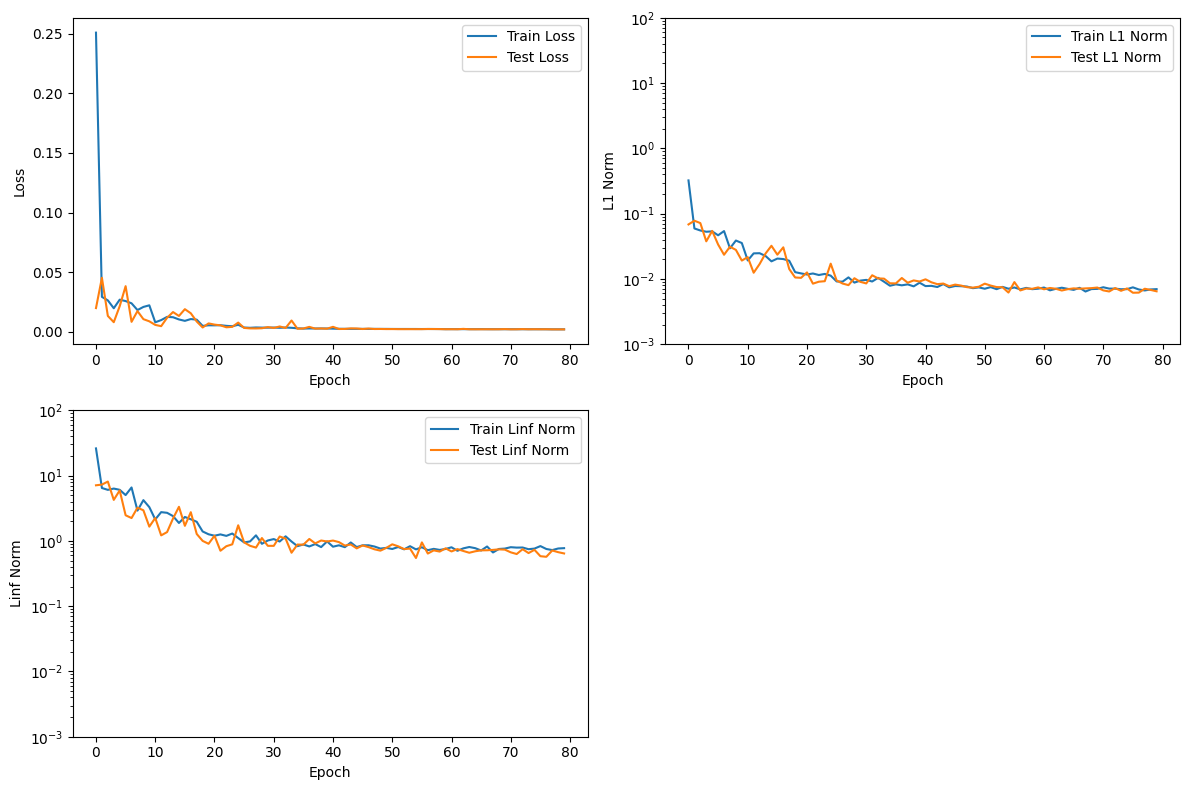

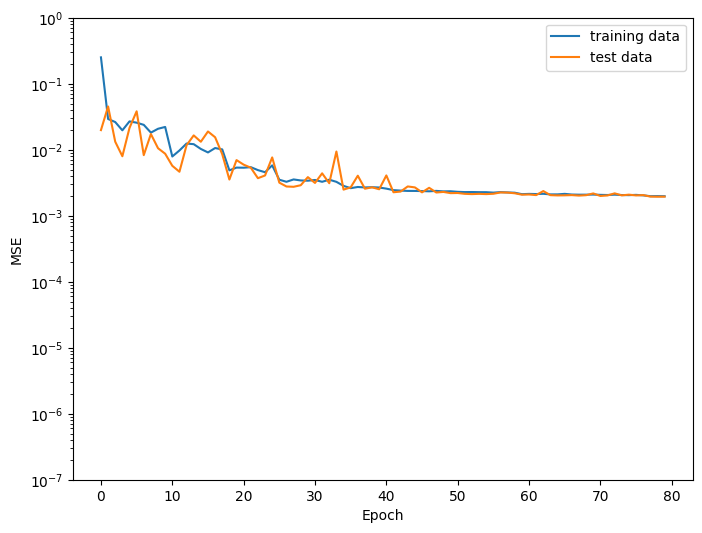

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Saving

In [ ]:
import json
import pandas as pd

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)


## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
  output_activation_loaded = nn.ReLU()
else:
  output_activation_loaded = nn.Identity()

# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
net_loaded.load_state_dict(torch.load("net.pth"))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
if optimizer_name_loaded == "SGD":
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded)
elif optimizer_name_loaded == "Adam":
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded)
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(torch.load("optimizer.pth"))

if scheduler_name_loaded == "StepLR":
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=10, gamma=0.1)
elif scheduler_name_loaded == "ExponentialLR":
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=0.9)
elif scheduler_name_loaded == "CosineAnnealingLR":
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=10)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode="min", factor=0.5, patience=5, threshold=0.0005, min_lr=1e-6
                )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  scheduler_loaded.load_state_dict(torch.load("scheduler.pth"))
            

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

In [ ]:
batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
loss_fn_loaded
optimizer_loaded
scheduler_loaded
#train_losses_loaded
#test_losses_loaded
#train_metrics_loaded
#test_metrics_loaded

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network.

In [ ]:
print(list(net.parameters()))

[Parameter containing:
tensor([[-0.1816,  0.2416,  0.1458],
        [ 0.1680,  0.2238,  0.5390],
        [-0.2251,  0.4058,  0.2923],
        [ 0.1841, -0.1964, -0.5651],
        [ 0.4065, -0.4723, -0.2989],
        [ 0.0348, -0.5174,  0.0283],
        [-0.0176, -0.1592, -0.0652],
        [ 0.0814, -0.4233, -0.2894],
        [ 0.1915,  0.1563, -0.5330],
        [-0.3292,  0.0648,  0.1497],
        [-0.1158,  0.1737, -0.4455],
        [ 0.1846,  0.1262, -0.4480],
        [-0.4479, -0.1709,  0.2345],
        [-0.5328, -0.0428, -0.4879],
        [-0.1409,  0.3124,  0.0978],
        [ 0.0586, -0.0848, -0.4315],
        [-0.0442,  0.2014, -0.2654],
        [ 0.5497, -0.0971,  0.0487],
        [-0.2611,  0.1713,  0.4188],
        [ 0.3880,  0.4476,  0.2861],
        [ 0.1013,  0.4242,  0.4531],
        [ 0.0072,  0.0826, -0.5139],
        [-0.2004, -0.5569,  0.0115],
        [-0.3911, -0.0206, -0.3195],
        [ 0.1241, -0.4230,  0.5179],
        [ 0.1318, -0.1224, -0.3227],
        [-0.259

In [ ]:
print(list(net_loaded.parameters()))

[Parameter containing:
tensor([[-0.1816,  0.2416,  0.1458],
        [ 0.1680,  0.2238,  0.5390],
        [-0.2251,  0.4058,  0.2923],
        [ 0.1841, -0.1964, -0.5651],
        [ 0.4065, -0.4723, -0.2989],
        [ 0.0348, -0.5174,  0.0283],
        [-0.0176, -0.1592, -0.0652],
        [ 0.0814, -0.4233, -0.2894],
        [ 0.1915,  0.1563, -0.5330],
        [-0.3292,  0.0648,  0.1497],
        [-0.1158,  0.1737, -0.4455],
        [ 0.1846,  0.1262, -0.4480],
        [-0.4479, -0.1709,  0.2345],
        [-0.5328, -0.0428, -0.4879],
        [-0.1409,  0.3124,  0.0978],
        [ 0.0586, -0.0848, -0.4315],
        [-0.0442,  0.2014, -0.2654],
        [ 0.5497, -0.0971,  0.0487],
        [-0.2611,  0.1713,  0.4188],
        [ 0.3880,  0.4476,  0.2861],
        [ 0.1013,  0.4242,  0.4531],
        [ 0.0072,  0.0826, -0.5139],
        [-0.2004, -0.5569,  0.0115],
        [-0.3911, -0.0206, -0.3195],
        [ 0.1241, -0.4230,  0.5179],
        [ 0.1318, -0.1224, -0.3227],
        [-0.259

In [ ]:
# Set the network to evaluation mode
net.eval()

Net(
  (hidden_activation): ReLU()
  (output_activation): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=78, bias=True)
    (1): Linear(in_features=78, out_features=193, bias=True)
    (2): Linear(in_features=193, out_features=99, bias=True)
    (3): Linear(in_features=99, out_features=1, bias=True)
  )
)

In [ ]:
rho_example, vx_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, epsilon_example)
inputs

tensor([[ 8.4823,  1.2874,  3.8433],
        [ 6.3628,  4.5830,  6.8709],
        [ 9.5007, 10.5686, 14.5369],
        [ 2.7702,  9.1947,  8.4208],
        [ 8.1549,  8.1288,  4.1824],
        [ 2.8599,  0.6266,  5.7706],
        [ 9.4994, 24.8554, 24.3957],
        [ 5.9511,  6.8335,  5.0241],
        [ 1.0827,  0.7347,  1.1826],
        [ 3.3039,  4.2094,  4.9122],
        [ 5.1887, 10.3858,  9.6000],
        [ 8.6661, 16.7210, 16.3864],
        [ 6.5375,  1.9848,  7.9297],
        [ 9.7648, 31.8522, 29.5890],
        [12.9340, 11.8892,  5.2417],
        [ 9.3644,  3.6599,  3.9022],
        [ 3.9849, 10.0192,  8.5279],
        [ 0.7702,  1.3431,  0.9888],
        [ 9.5696,  0.1444,  2.6998],
        [ 7.7714, 11.4869, 16.6507]], device='cuda:0')

In [ ]:
# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

[tensor([2.5049], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([3.9185], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([7.7054], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([1.8241], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.5939], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([3.8254], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([7.5994], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([1.5006], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.6895], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([2.3389], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([3.0083], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([5.8099], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([5.1749], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([6.8878], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.4149], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([2.2030], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([1.7647], device='cuda:0', grad_

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()
# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

[tensor([2.5049], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([3.9185], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([7.7054], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([1.8241], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.5939], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([3.8254], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([7.5994], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([1.5006], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.6895], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([2.3389], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([3.0083], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([5.8099], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([5.1749], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([6.8878], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.4149], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([2.2030], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([1.7647], device='cuda:0', grad_

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 3) to trace the model
dummy_input = torch.randn(1, 3).to(device)
dummy_input

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)

tensor([[2.4332]], device='cuda:0', grad_fn=<AddmmBackward0>)